
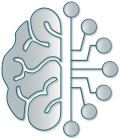

**Start at:** Monday 17 June 2024, 15:19:37  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [15]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color,fg,hl,bg
vID.init(cwd0)

import tools4pyPhysChem as t4pPC

#cancel the "last operation show-up" specific of Jupyter notebooks
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


# Prediction by an artificial neural network of the solubility of CO<sub>2</sub> in ionic liquids

<div class="intro">
    
<b>Reference</b>: 
Z. Song, H. Shi, X. Zhang & T. Zhou (**2020**), Prediction of CO<sub>2</sub> solubility in ionic liquids using machine learning methods, [<i>Chem. Eng. Sci.</i> <b>223</b>: 115752](https://www.doi.org/10.1016/j.ces.2020.115752) 
<br>
<p style="text-align: center"><img width="650px" src="./DS4B-CO2-images/AbstractANNCO2-SongEtal.png" style="margin-left:auto; margin-right:auto" id="img_AbstractSong"></p>
<br>
The main results are graphically reported below.
<br>
<p style="text-align: center"><img width="900px" src="./DS4B-CO2-images/ANNCO2-SongEtal-Results.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>
<br>

**The goal of this tutorial is to reproduce the ANN part of this article, which is an example of application of a DFF**

<img src="./DS4B-Slides/pngs/ZooNN/DFF-C.png" alt="DFF" width="180" style="display: block; margin: 0 auto; align:center" id="DFF"/>
</div>


In [16]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
    
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os,sys
from IPython.display import display

<a id="data-read"></a>
## Basic data analysis and visualization

<div class="intro">

The [pandas library](https://pandas.pydata.org/docs/index.html) provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language. It is recommended to first have a look at the [10mn short introduction to pandas](https://pandas.pydata.org/docs/user_guide/10min.html).
</div>

### Read the database

<div class="intro">

It is made of 57 columns:
- the name of the IL, under its abbreviated form. For example [BMIM][PF6] is for [1-Butyl-3-methylimidazolium hexafluorophosphate](https://en.wikipedia.org/wiki/1-Butyl-3-methylimidazolium_hexafluorophosphate)
- the abbreviated name of the cation and of the anion in two separated columns
- the CO<sub>2</sub> solubility (x_CO2)
- the temperature and pressure under which the solubility was measured 
- the 51 remaining columns are molecular descriptors. The authors chose:
    - group contribution (GC) descriptors for the cations, *i.e.* the occurrences of functional groups in the molecule
    - a one hot encoding scheme for anions, e.g. [1,0,...,0] (with 27 zeros) for [BF4], which is the first anion of this database, that contains ILs made of 28 different anions
</div>

In [17]:
dataCO2f='DS4B-CO2-data'+'/'+'dataCO2.csv'
dataCO2=pd.read_csv(dataCO2f,sep=";",header=0)
display(dataCO2)
# describe() generates descriptive statistics
display(dataCO2.describe().style.format("{0:.2f}"))


,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10115,[HMIM][Tf2N],[HMIM],[Tf2N],0.139,323.15,8.00,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.33,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.24,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,0.00,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.30,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.51,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.95,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [18]:
t4pPC.centerTitle("Unique ILs")
nIL = dataCO2["IL"].nunique()
print(f"There are {nIL} different ionic liquids in this database")
print(dataCO2["IL"].unique())

t4pPC.centerTitle("Unique cations")
nCat = dataCO2["cation"].nunique()
print(f"There are {nCat} different cations in this database")
print(dataCO2["cation"].unique())

t4pPC.centerTitle("Unique anions")
nAn = dataCO2["anion"].nunique()
print(f"There are {nAn} different anions in this database")
print(dataCO2["anion"].unique())

There are 124 different ionic liquids in this database
['[BMIM][BF4]' '[BMIM][SCN]' '[(ETO)2IM][Tf2N]' '[BBIM][MeSO3]'
 '[BMIM][MeSO3]' '[EMIM][MeSO3]' '[MMIM][MeSO3]' '[BMIM][DCA]'
 '[BMIM][methide]' '[BMIM][NO3]' '[BMIM][PF6]' '[BMIM][Tf2N]'
 '[HMIM][Tf2N]' '[HMMIM][Tf2N]' '[OMIM][Tf2N]' '[BMIM][TfO]'
 '[BMPYR][Tf2N]' '[N1,4,4,4][Tf2N]' '[P1,4,4,4][TOS]' '[HMIM][BF4]'
 '[OMIM][BF4]' '[P4,4,4,4][FOR]' '[EMIM][Tf2N]' '[BMIM][TFA]'
 '[EMIM][TFA]' '[BMIM][Cl]' '[BMIM][DBPO4]' '[EMIM][DEPO4]'
 '[MMIM][DMPO4]' '[BMIM][MDEGSO4]' '[C6F9MIM][Tf2N]' '[C8F13MIM][Tf2N]'
 '[HMPY][Tf2N]' '[N1,1,1,2-OH][Tf2N]' '[N4,1,1,1][Tf2N]' '[P6,6,6,14][Cl]'
 '[DMIM][Tf2N]' '[N1,8,8,8][Tf2N]' '[P6,6,6,14][Tf2N]' '[BMIM][MeSO4]'
 '[C4PY][BF4]' '[EMIM][EtSO4]' '[OMIM][PF6]' '[EMIM][TfO]' '[HMIM][TfO]'
 '[OMIM][TfO]' '[HOC3MIM][NO3]' '[EMIM][DCA]' '[BMPYR][TfO]' '[EMIM][BF4]'
 '[HMIM][PF6]' '[NMIM][PF6]' '[BMPYR][MeSO4]' '[N1,1,3,2-OH][Tf2N]'
 '[C5MIM][Tf2N]' '[C5MPYR][Tf2N]' '[C7MPYR][Tf2N]' '[C9MPYR][Tf2N]'
 '[

There are 56 different cations in this database
['[BMIM]' '[(ETO)2IM]' '[BBIM]' '[EMIM]' '[MMIM]' '[HMIM]' '[HMMIM]'
 '[OMIM]' '[BMPYR]' '[N1,4,4,4]' '[P1,4,4,4]' '[P4,4,4,4]' '[C6F9MIM]'
 '[C8F13MIM]' '[HMPY]' '[N1,1,1,2-OH]' '[N4,1,1,1]' '[P6,6,6,14]' '[DMIM]'
 '[N1,8,8,8]' '[C4PY]' '[HOC3MIM]' '[NMIM]' '[N1,1,3,2-OH]' '[C5MIM]'
 '[C5MPYR]' '[C7MPYR]' '[C9MPYR]' '[HOC2MIM]' '[he]' '[hea]' '[N2,1,1,3]'
 '[HMPYR]' '[OMPYR]' '[m-2-HEA]' '[MDEA]' '[HOEPY]' '[C3MPYR]'
 '[P2,4,4,4]' '[N4,4,4,4]' '[COCMPYR]' '[aMIM]' '[deme]' '[PMIM]' '[S222]'
 '[thma]' '[C4MPY]' '[N6,1,1,1]' '[PMPip]' '[BMMIM]' '[PMPY]' '[C3OMIM]'
 '[C5O2MIM]' '[oleyl-MIM]' '[C12MIM]' '[C7MIM]']


There are 28 different anions in this database
['[BF4]' '[SCN]' '[Tf2N]' '[MeSO3]' '[DCA]' '[methide]' '[NO3]' '[PF6]'
 '[TfO]' '[TOS]' '[FOR]' '[TFA]' '[Cl]' '[DBPO4]' '[DEPO4]' '[DMPO4]'
 '[MDEGSO4]' '[MeSO4]' '[EtSO4]' '[C12PhSO3]' '[TCB]' '[C3F7CO2]' '[HSO4]'
 '[FSA]' '[C(CN)3]' '[NfO]' '[BETA]' '[TDfO]']


### How do the cations an anions look like?

<div class="intro">

Their SMILES coding is available in a separated csv file. `rdkit` will now be used to see the 2D structure of these species. The SMILES must first be converted into rdkit `mol` objects. 
</div>

In [5]:
import rdkit
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
print(f"{color.BOLD}{color.BLUE}Version of rdkit : {rdkit.__version__}{color.OFF}")
fSMILESILs='DS4B-CO2-data'+'/'+'dataCO2_SMILES_ILsList.csv'
SMILESILs=pd.read_csv(fSMILESILs,sep="\t",header=0)
display(SMILESILs)

Version of rdkit : 2022.09.5


,Cation or Anion,Abbreviation,Full Name,SMILES
0,Cation,[MMIM],"1,3-dimethyl-imidazolium",[N+]1(C)=CN(C=C1)C
1,Cation,[EMIM],1-ethyl-3-methyl-imidazolium,[N+]1(CC)=CN(C=C1)C
2,Cation,[PMIM],1-propyl-3-methylimidazolium,[N+]1(CCC)=CN(C=C1)C
3,Cation,[BMIM],1-butyl-3-methyl-imidazolium,[N+]1(CCCC)=CN(C=C1)C
4,Cation,[C5MIM],1-pentyl-3-methyl-imidazolium,[N+]1(CCCCC)=CN(C=C1)C
...,...,...,...,...
79,Anion,[C12PhSO3],dodecylbenzenesulfonate,C1(CCCCCCCCCCCC)C=CC(=CC=1)S(=O)(=O)[O-]
80,Anion,[DMPO4],dimethylphosphate,[O-]P(=O)(OC)OC
81,Anion,[DEPO4],diethylphosphate,O=P([O-])(OCC)OCC
82,Anion,[DBPO4],dibutylphosphate,O=P([O-])(OCCCC)OCCCC


/home/romuald/Python3/ML/lib64/python3.11/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)
/home/romuald/Python3/ML/lib64/python3.11/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)
/home/romuald/Python3/ML/lib64/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:120: FutureWarning: DataFrame.applymap has been 

,Cation or Anion,Abbreviation,Full Name,SMILES,ROMol
0,Cation,[MMIM],"1,3-dimethyl-imidazolium",[N+]1(C)=CN(C=C1)C,
1,Cation,[EMIM],1-ethyl-3-methyl-imidazolium,[N+]1(CC)=CN(C=C1)C,
...,...,...,...,...,...
54,Cation,"[P6,6,6,14]",trihexyl(tetradecyl)phosphonium,CCCCCC[P+](CCCCCCCCCCCCCC)(CCCCCC)CCCCCC,
55,Cation,[S222],triethylsulfonium,CC[S+](CC)CC,

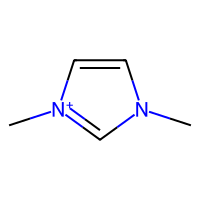
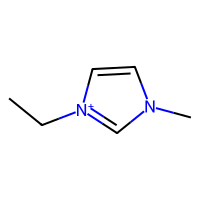
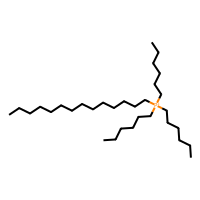
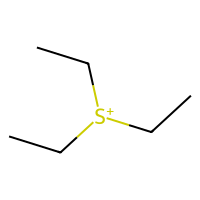

/home/romuald/Python3/ML/lib64/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:120: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Cation or Anion,Abbreviation,Full Name,SMILES,ROMol
56,Anion,[BF4],tetrafluoroborate,F[B-](F)(F)F,
57,Anion,[Cl],chloride,[Cl-],
...,...,...,...,...,...
82,Anion,[DBPO4],dibutylphosphate,O=P([O-])(OCCCC)OCCCC,
83,Anion,[methide],tris(trifluoromethylsulfonyl)methide,O=S(=O)([C-](S(=O)(=O)C(F)(F)F)S(=O)(=O)C(F)(F...,

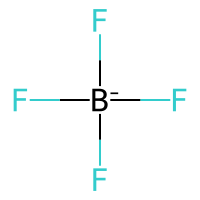
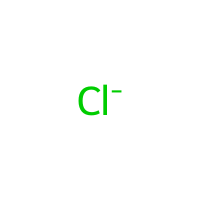
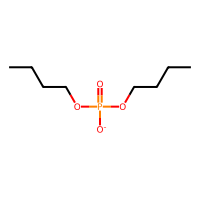
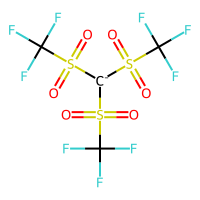

In [19]:
ILcation=SMILESILs[SMILESILs['Cation or Anion'] == 'Cation']
ILanion=SMILESILs[SMILESILs['Cation or Anion'] == 'Anion']
PandasTools.AddMoleculeColumnToFrame(ILcation, smilesCol='SMILES')
PandasTools.AddMoleculeColumnToFrame(ILanion, smilesCol='SMILES')
pd.options.display.max_rows = 5
display(ILcation)
display(ILanion)

#### Display cations on a grid

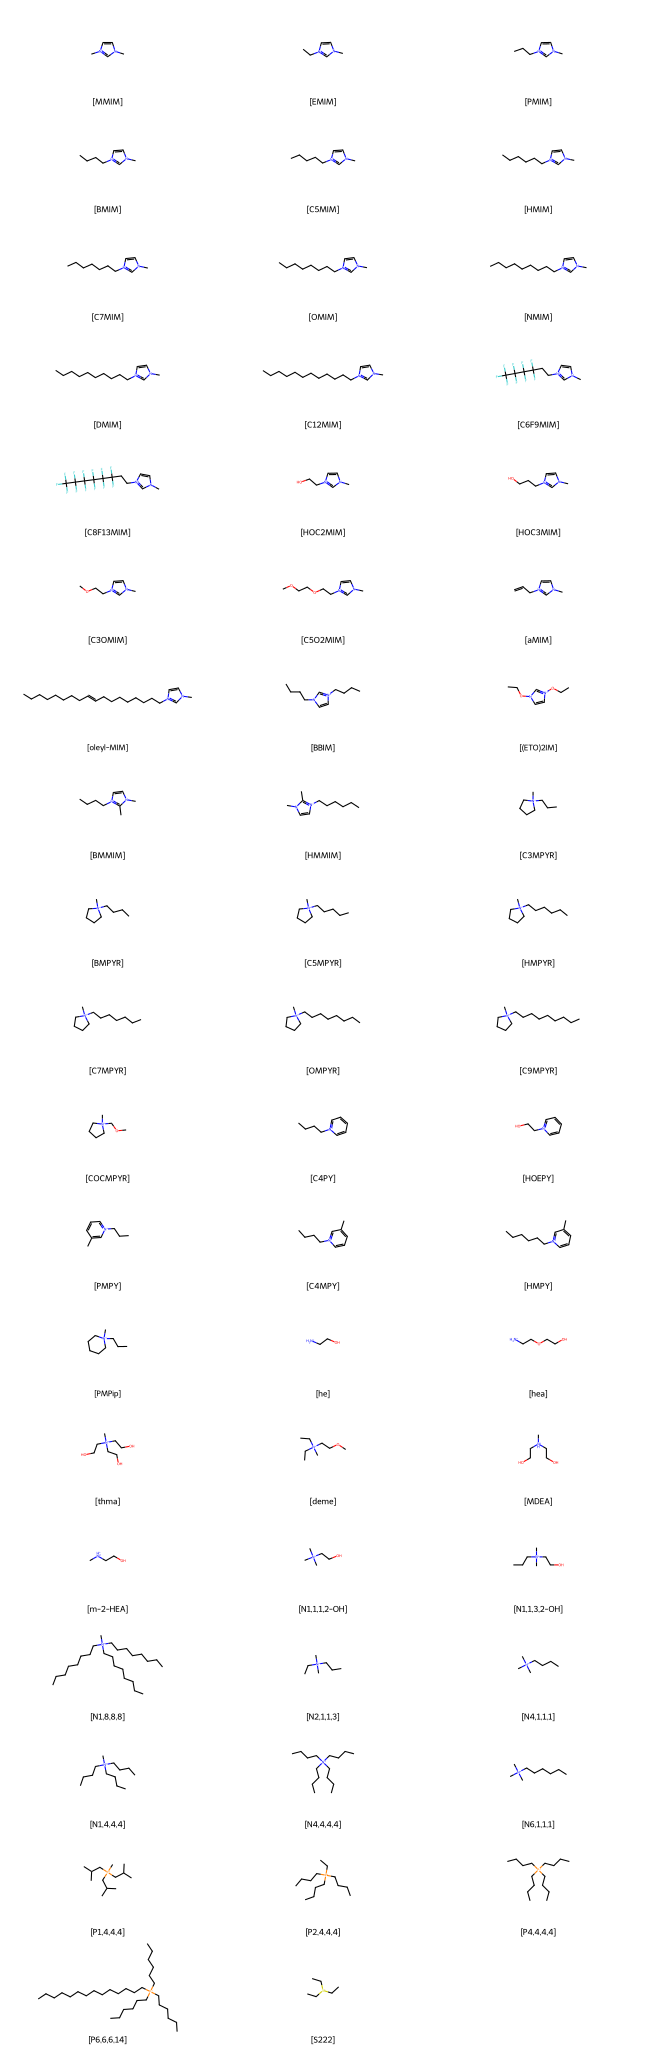

In [20]:
IPythonConsole.drawOptions.bondLineWidth=2
#FrameToGridImage: Draw grid image of mols in pandas DataFrame
PandasTools.FrameToGridImage(ILcation, molsPerRow=3, legendsCol='Abbreviation', useSVG=True, subImgSize=(400, 200), maxMols=ILcation.shape[0])

#### Display anions on a grid

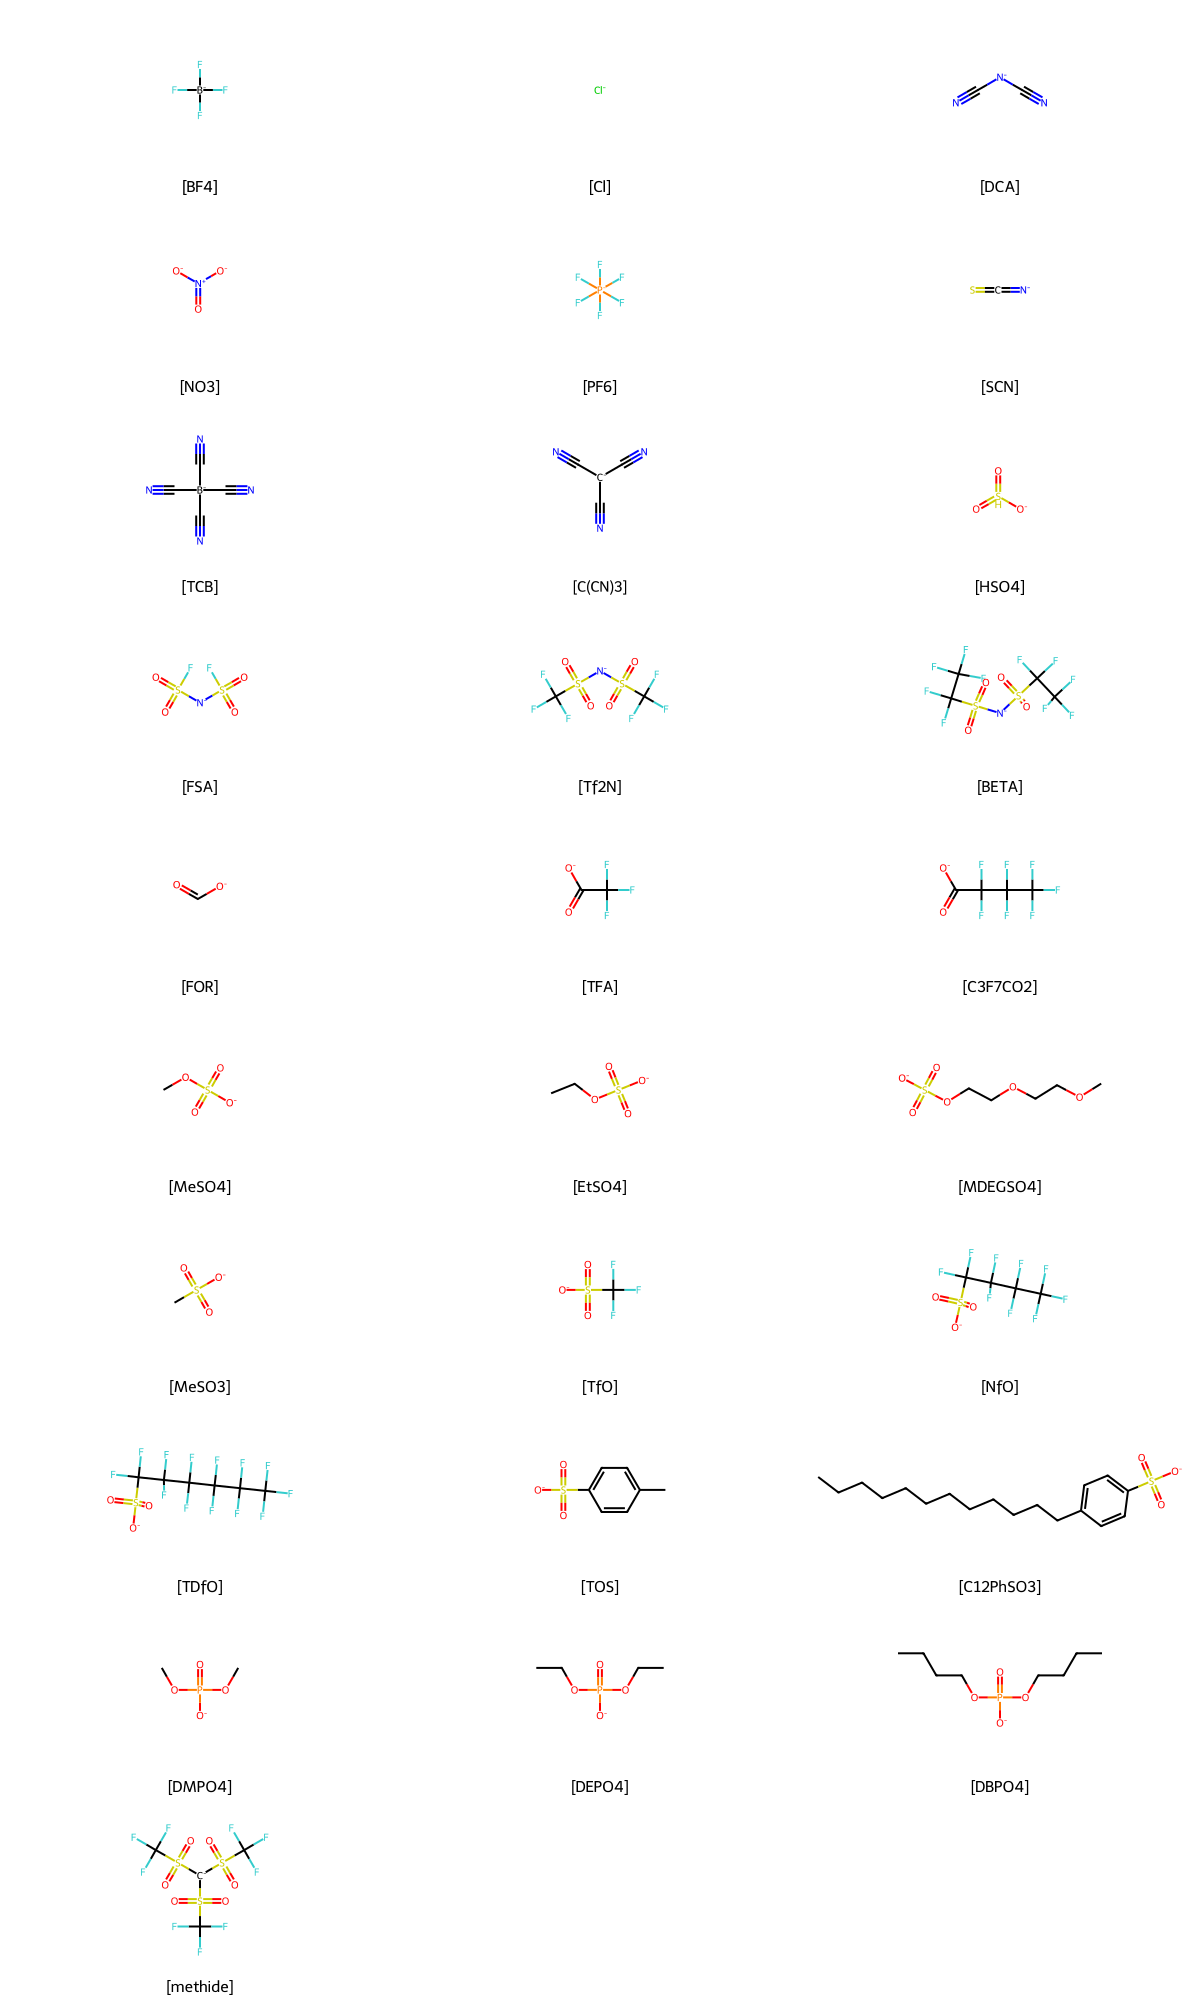

In [21]:
IPythonConsole.drawOptions.bondLineWidth=2
#FrameToGridImage: Draw grid image of mols in pandas DataFrame
PandasTools.FrameToGridImage(ILanion, molsPerRow=3, legendsCol='Abbreviation', useSVG=True, subImgSize=(400, 200), maxMols=ILcation.shape[0])

### Data distribution?

       x_CO2
[CH3]       
0        855
1       8350
...      ...
4        639
7         72

[6 rows x 1 columns]

Duration :  00:00:01 767ms


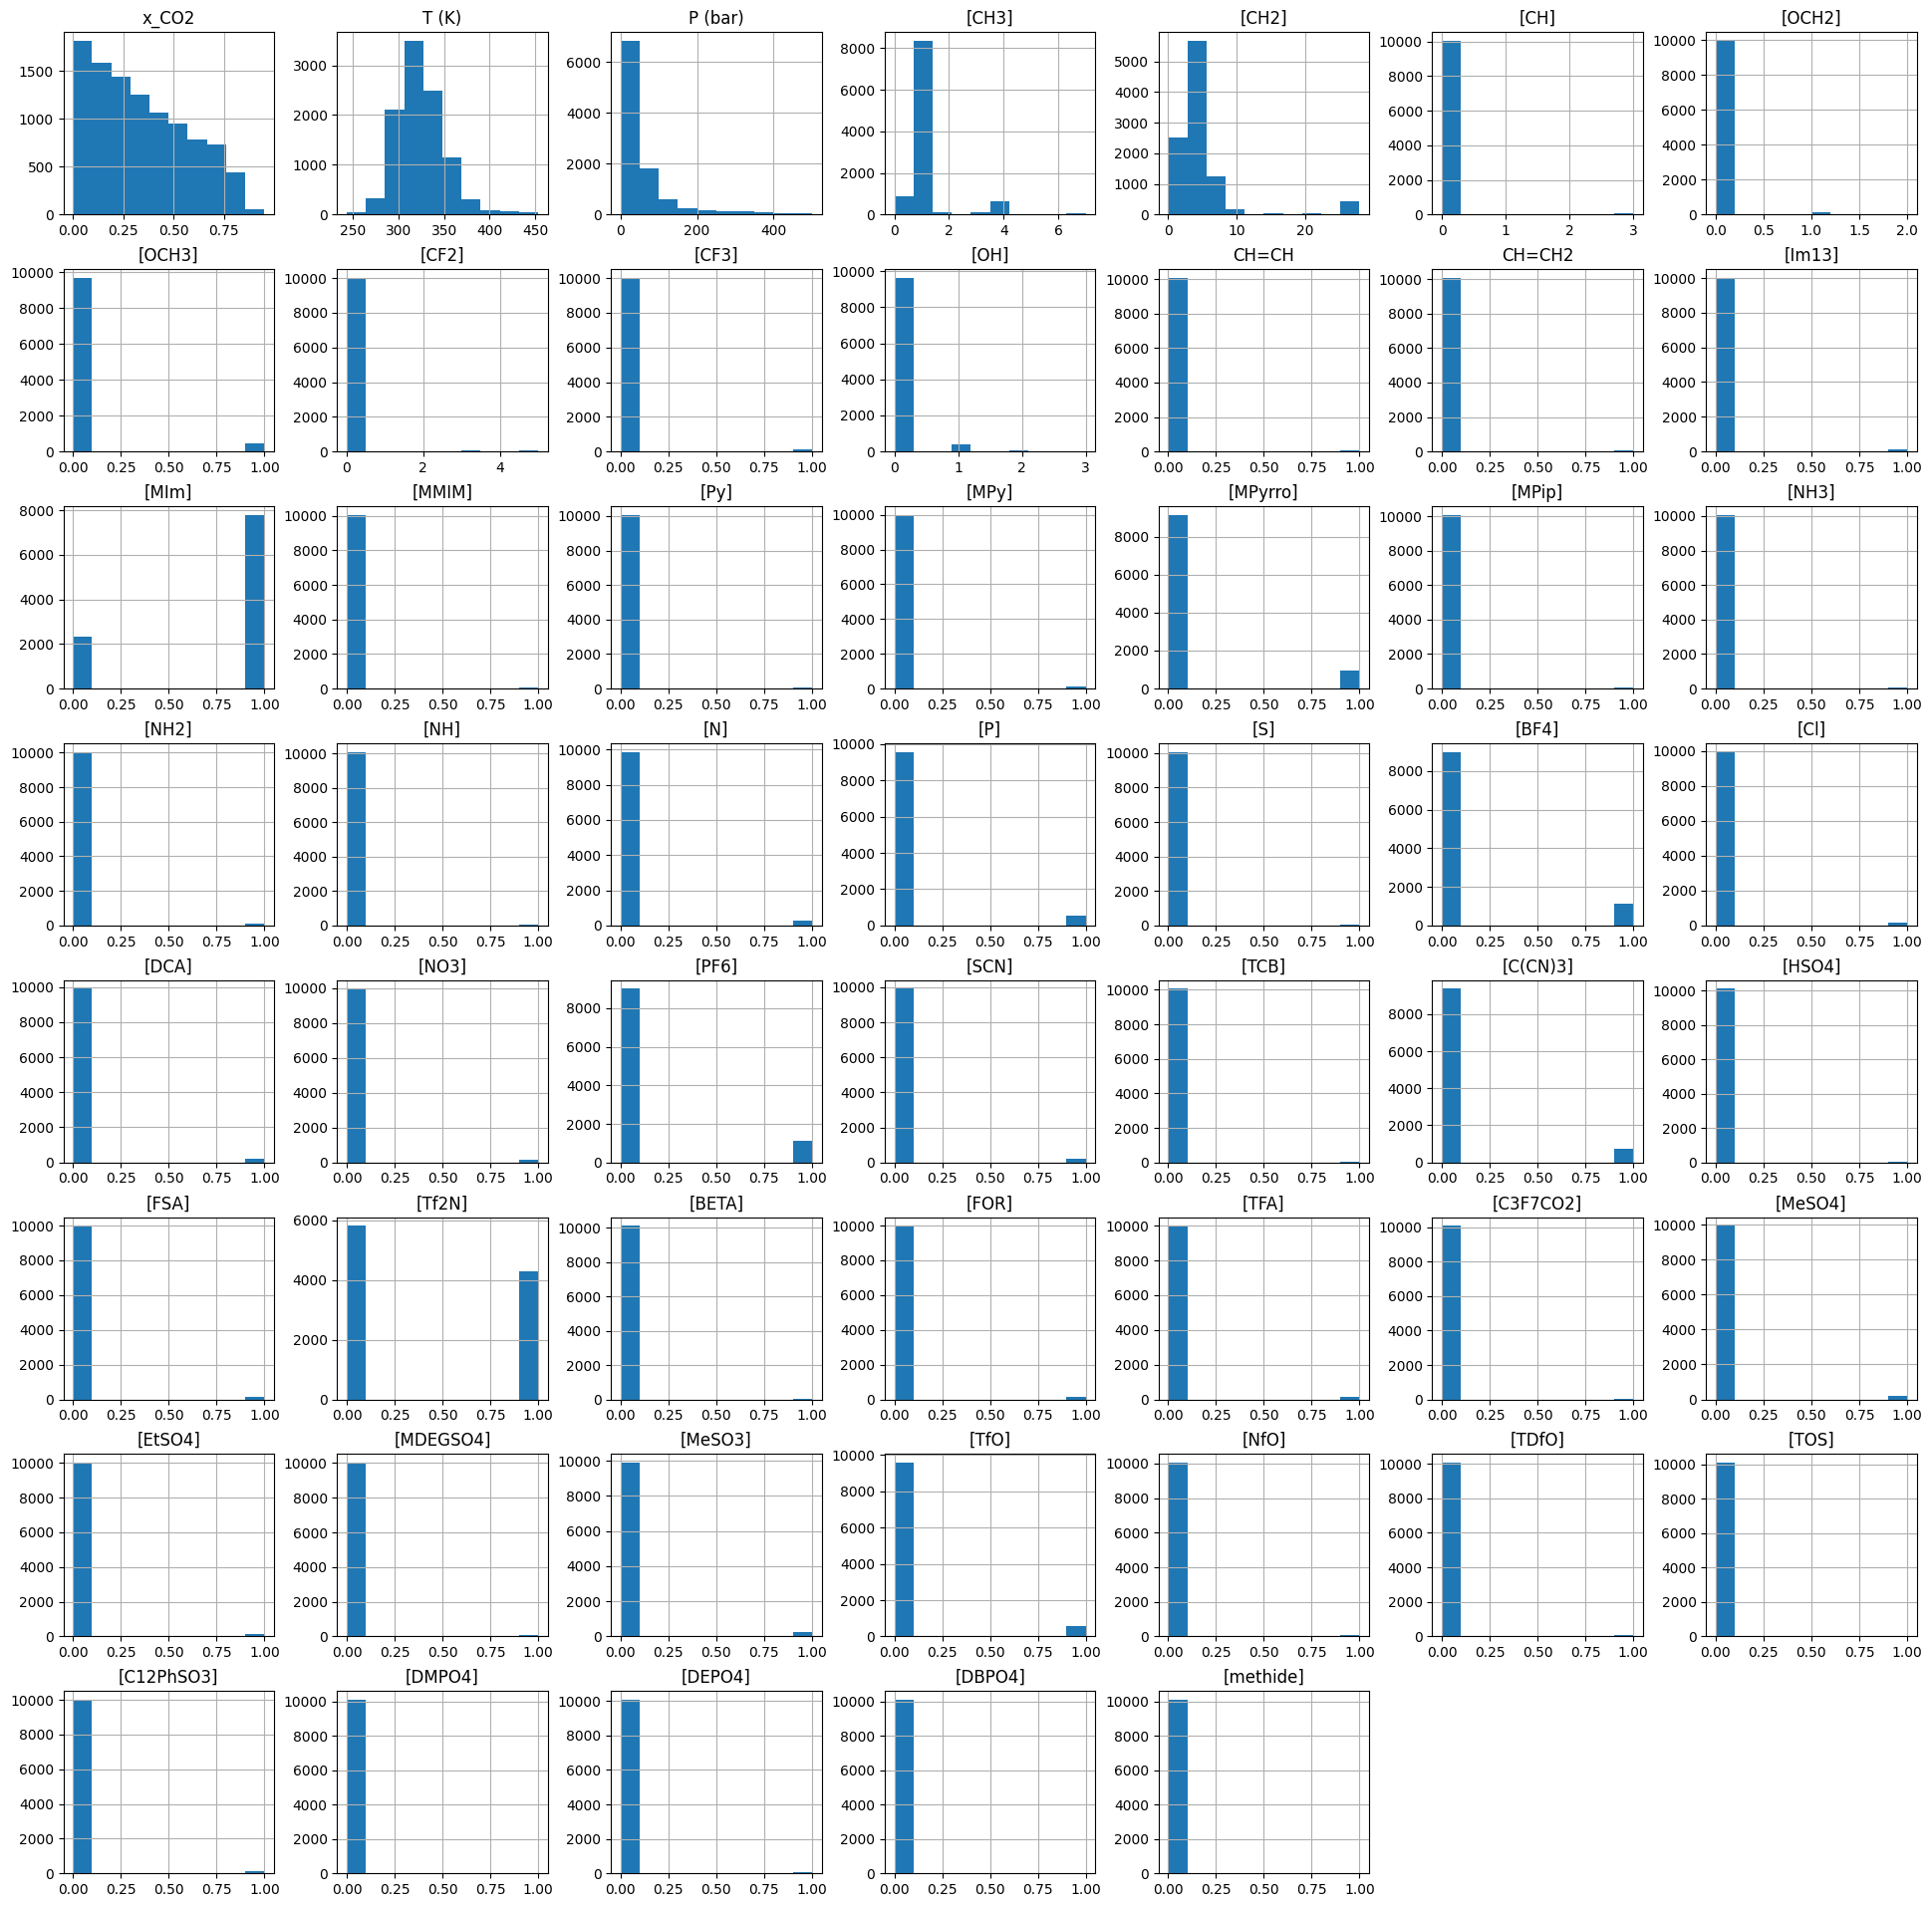

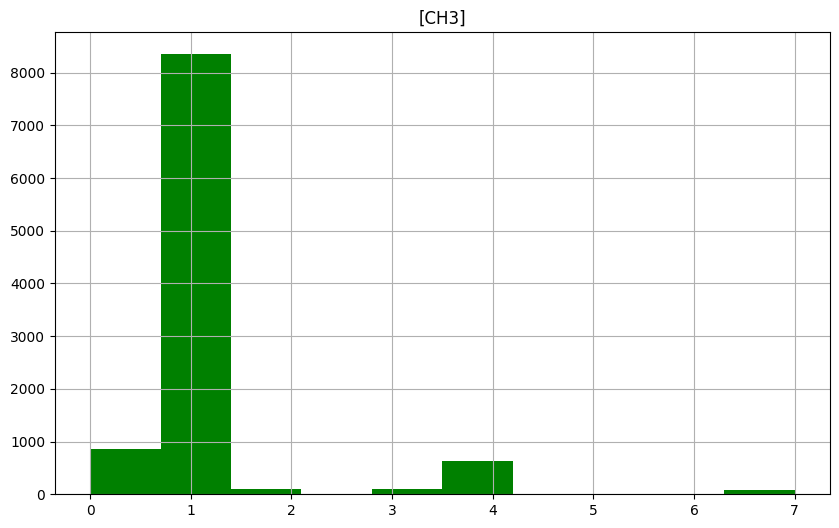

In [22]:
vID.chrono_start()
dataCO2.hist(figsize=(24,24))
print(dataCO2[["x_CO2", "[CH3]"]].groupby("[CH3]").count())
dataCO2.hist("[CH3]",figsize=(10,6),facecolor='g')
vID.chrono_show()

## Prediction of the solubility of CO<sub>2</sub> by an ANN: <br>a textbook case of work that does not quite meet the standards of the field 

### ML scheme of the reference article

<div class="intro">
    
<p style="text-align: center"><img width="800px" src="./DS4B-CO2-images/ANN-CO2Song_etal.png" style="margin-left:auto; margin-right:auto" id="img_Song"></p>

**Methodological details (excerpts from the article):**
- The MATLAB tansig and purelin transfer functions are employed in the hidden and output layers, respectively
- The experimental data are divided into a training set (8093 points, 80% of the data) to build the model and a test set of the remaining 2023 data points to evaluate the predictive capability of the obtained model
- <span style="color:red"><b>!!!</b> Instead of performing random selection, we employ a hybrid artificial-random strategy to decompose the dataset. Specifically, the data points consisting of the least frequently used groups are equally divided into five folders <b>!!!</b></span> 

</div>
<br>
<div class="rqT" title="Warning!">

This "*hybrid artificial-random strategy*" is not a valid strategy. The recommended K-fold cross validation, applied to the 3rd model, cannot be applied here!

**Let's observe now the weird behaviour of this model**
</div>

### Useful functions

In [23]:
def plotModel(model, model_id, MODELS_PATH=".", fig_extension="png", resolution=300,
              show_shapes=True, show_layer_names=True, show_layer_activations=True):
    '''
    saves a model plot to a given subfolder, that will be created if it does not exist
    input:
        - model = keras model
        - model_id = name of the model file, without an extension
        - MODELS_PATH = pathway to the folder. Default: "."
        - model_extension = model type. Default: png
    '''
    from tensorflow.keras.utils import plot_model
    from matplotlib.pyplot import plot
    path = MODELS_PATH / f"{model_id}.{fig_extension}"
    plot_model(model, to_file=path, dpi=resolution, show_shapes=show_shapes, 
               show_layer_names=show_layer_names, show_layer_activations=show_layer_activations)
    img = plt.imread(path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return


### Model 1: assesment of the reproducibility of the simulation of Song *et al.*<a id="model1"></a>

<div class = "intro">
    
Errors calculated between the actual and predicted x_CO2 values (noted $Y$ and $\hat{Y}$ in equations below)  
MAE =  Mean Absolute Error 
$$\mathrm{MAE}=\frac{1}{n}\sum_{i}\left|\hat{Y}(x_{i})-Y(x_{i})\right|$$

MSE = Mean Squared Error  
$$\mathrm{MSE}=\frac{1}{n}\sum_{i}\left(\hat{Y}(x_{i})-Y(x_{i})\right)^{2}$$

</div>

#### Split the data into train and test sets

In [24]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
data_train = dataCO2.sample(frac=0.8, axis=0)
data_test  = dataCO2.drop(data_train.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']

display(x_train,y_train)
display(x_test,y_test)

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
6733,364.03,74.42,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2045,323.17,11.00,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5046,318.05,170.80,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4493,303.48,21.85,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


6733    0.5007
2045    0.1960
         ...  
5046    0.5080
4493    0.4180
Name: x_CO2, Length: 8093, dtype: float64

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
7,333.15,162.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,357.15,154.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10109,323.15,54.30,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10111,298.15,35.86,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


7        0.610
9        0.500
         ...  
10109    0.583
10111    0.592
Name: x_CO2, Length: 2023, dtype: float64

#### Define the ANN

In [25]:
#######################################################################################
# ANN: 1 input layer (53 neurons) / 1 hidden layer (7 neurons with the reLu activation function) / 1 output layer (1 neuron with no activation function) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'
#acthL='relu'
if 'ANNmodel' in globals():
    del ANNmodel
if 'ANNhistory' in globals():
    del ANNhistory
ANNmodel=defANN( (53,), acthL )
ANNmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer (Dense)                  │ (None, 7)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386 (1.51 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

#### Plot the model

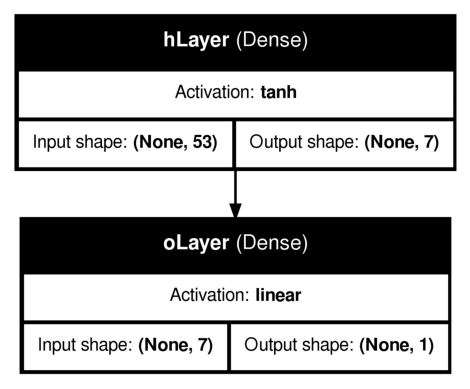

In [26]:
from pathlib import Path

MODELS_PATH = Path() / "DS4B-CO2-SavedModels"
MODELS_PATH.mkdir(parents=True, exist_ok=True)
plotModel(ANNmodel, "Model1_CO2", MODELS_PATH=MODELS_PATH)

#### Train the ANN

In [27]:
#######################################################################################
# optimization of the ANN
# library used: keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 300,
                    batch_size      = 20,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ytrain_hat=ANNmodel.predict(x_train)
ytest_hat=ANNmodel.predict(x_test)
# numpy.ravel() returns a contiguous flattened array
diffyt = ytrain_hat - y_train.to_numpy()
diffyp = ytest_hat - y_test.to_numpy()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt),
      "   std: ", np.std(diffyt),
      "   MAE: ", np.average(abs(diffyt)),
      "    R2: ", np.corrcoef(y_train.to_numpy(),ytrain_hat.flatten())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp),
      "   std: ", np.std(diffyp),
      "   MAE: ", np.average(abs(diffyp)),
      "    R2: ", np.corrcoef(y_test.to_numpy(),ytest_hat.flatten())[0,1]
     )


Epoch 1/300
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3020 - mae: 0.4526 - mse: 0.3020 - val_loss: 0.0560 - val_mae: 0.1946 - val_mse: 0.0560
Epoch 2/300
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.0522 - mae: 0.1887 - mse: 0.0522 - val_loss: 0.0477 - val_mae: 0.1809 - val_mse: 0.0477
Epoch 3/300
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0461 - mae: 0.1770 - mse: 0.0461 - val_loss: 0.0464 - val_mae: 0.1786 - val_mse: 0.0464
Epoch 4/300
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0452 - mae: 0.1766 - mse: 0.0452 - val_loss: 0.0429 - val_mae: 0.1719 - val_mse: 0.0429
Epoch 5/300
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0429 - mae: 0.1720 - mse: 0.0429 - val_loss: 0.0401 - val_mae: 0.1660 - val_mse: 0.0401
Epoch 6/300
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0410 - mae: 0.1669 - mse: 0.0410 - val_loss: 0.0431 - val_mae: 0.1677 - val_mse: 0.0431
Epoch 7/300
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.0404 - mae: 0.1662 - 

<div class="rq"><span style="color:red; font-weight:bold">The MAE and R2 parameters seem rather good (<i>ca.</i> 0.07 and 0.92), but this prediction is actually very bad, as you will see by jumping to the <a href="#model-evaluation">Model Evaluation</a> section!</span>
<br>
<br>  
Unless you were lucky (an element of chance is involved in the learning process), the predicted <i>vs.</i> actual CO<sub>2</sub> solubility probably looks like this: 
<br>
<p style="text-align: center"><img width="550px" src="./DS4B-CO2-images/predictionCO2_woStd-saved.png" style="margin-left:auto; margin-right:auto" id="img_predCO2woStd"></p>
<b>It differs a lot from the results of the reference article, reported in the introduction of this notebook.</b>
<br><br>
<span style="color:red; font-weight:bold">Origin of this weird behaviour?</span>
<br>
Probably the absence of <b>standardization</b> of the data. This scattering is by the way reminiscent the variation of the solubility as a function of <i>T</i> or <i>p</i>, plotted below. Let's check that in the next script.
</div>

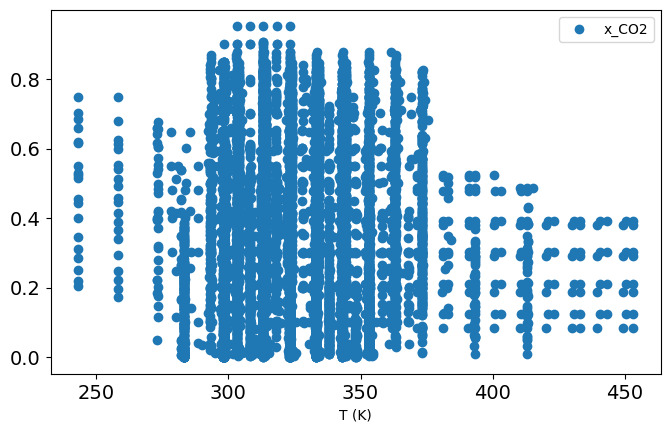

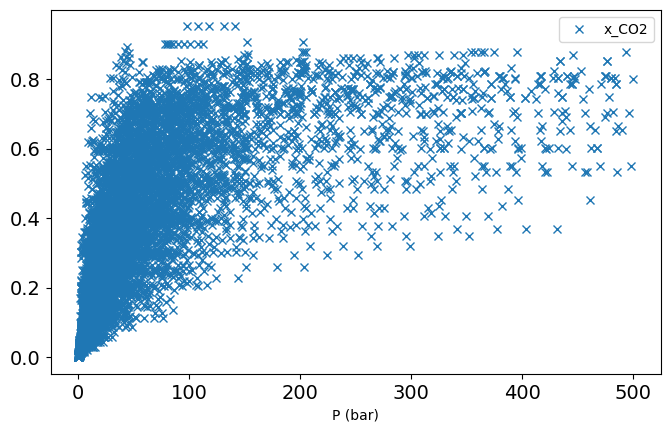

In [39]:
cm = 1/2.54
plt.rcParams["figure.figsize"] = (20*cm,12*cm) #graphic size
fig1=dataCO2.plot(x="T (K)", y=["x_CO2"],linestyle='', marker='o',fontsize=14)
fig2=dataCO2.plot(x="P (bar)", y=["x_CO2"],linestyle='', marker='x',fontsize=14)

#### Save the Keras ANN model for later use

In [40]:
ANNmodel.save('./DS4B-CO2-SavedModels/ANNmodel-CO2-basic.keras')

<a id="model2"></a>
## Model 2 = standardization of *T* and *p* only

<div class="rqT" title="What is standardization?">

**Standardization** is the process of translating and scaling our features so that they are all *distributed around a mean of zero* with a *standard deviation of one*.
    
Because the Temperature and pressure in the CO<sub>2</sub> dataset are on totally different scales, we need to scale them, **without changing their relative distribution**
    
We want to standardize our data so that the *covariances* are easily comparable for each pair of features. If we don’t do it, features with larger ranges of numbers will have higher covariances, which could be an artificial feature.
</div>

<br>
<div class="intro">

This new model  is an improvement of model 1, but without standardizing the GC descriptors which covariances are small. <br>
</div>
<br>

### Split into train and test sets

In [41]:
# Resets all state generated by Keras
tf.keras.backend.clear_session()

In [42]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
data_train = dataCO2.sample(frac=0.8, axis=0)
data_test  = dataCO2.drop(data_train.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']

#######################################################################################

# Train
x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
xIL_train = x_train.drop(['T (K)','P (bar)'],axis=1)
xTP_train = data_train[['T (K)','P (bar)']]
y_train = data_train['x_CO2']
x_trainTmp = x_train.copy() # for plotting purpose

# Test
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
xIL_test = x_test.drop(['T (K)','P (bar)'],axis=1)
xTP_test = data_test[['T (K)','P (bar)']]
y_test  = data_test['x_CO2']
x_testTmp = x_test.copy() # for plotting purpose

print(f"{bg.DARKREDB}Training set before normalization:{bg.OFF}")
display(x_train)
display(x_train.describe().style.format("{0:.2f}").set_caption("Training set before normalization:"))
print(f"{bg.DARKREDB}Test set before normalization:{bg.OFF}")
display(x_test)
display(x_test.describe().style.format("{0:.2f}").set_caption("Test set before normalization:"))

Training set before normalization:


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
9257,313.15,21.89,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5165,323.00,23.50,0,3,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6233,333.13,14.92,4,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8828,298.15,1.93,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,325.60,55.15,1.17,4.67,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.10,0.00,0.01,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.06,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00
std,25.31,78.23,0.96,5.38,0.26,0.17,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.07,0.07,0.10,0.30,0.06,0.07,0.08,0.06,0.15,0.22,0.06,0.31,0.13,0.15,0.12,0.32,0.14,0.08,0.26,0.04,0.12,0.49,0.03,0.11,0.10,0.05,0.13,0.10,0.10,0.15,0.23,0.09,0.07,0.06,0.10,0.04,0.07,0.04,0.05
min,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,323.15,27.25,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,343.11,65.35,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Test set before normalization:


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
8,373.15,160.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,357.15,154.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10103,298.15,89.67,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,298.15,20.15,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00
mean,323.97,50.47,1.20,4.95,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.01,0.01,0.08,0.00,0.00,0.01,0.00,0.03,0.06,0.00,0.12,0.01,0.02,0.02,0.10,0.02,0.00,0.08,0.00,0.01,0.42,0.00,0.01,0.02,0.00,0.01,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,24.95,69.92,0.98,5.88,0.23,0.13,0.20,0.40,0.10,0.29,0.07,0.06,0.10,0.42,0.10,0.08,0.11,0.27,0.07,0.05,0.10,0.05,0.16,0.24,0.06,0.32,0.11,0.14,0.13,0.30,0.13,0.07,0.26,0.03,0.11,0.49,0.03,0.12,0.14,0.05,0.12,0.12,0.10,0.15,0.22,0.09,0.09,0.07,0.11,0.02,0.09,0.05,0.04
min,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,303.85,9.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,323.15,24.73,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,335.78,62.64,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,453.15,497.60,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Scale independently T & P

In [43]:
# using scikit-learn
from sklearn import preprocessing

print(f"{bg.LIGHTBLUEB}Training set (T,P) after normalization:{bg.OFF}")
scalerTP = preprocessing.StandardScaler()
scalerTP.fit(xTP_train.values)
xTP_train_scaled = scalerTP.transform(xTP_train.values) #returns a numpy array
xTP_train = pd.DataFrame(xTP_train_scaled, index=xTP_train.index, columns=xTP_train.columns)
display(xTP_train)
display(xTP_train.describe().style.format("{0:.2f}"))

print(f"{bg.LIGHTBLUEB}Test set (T,P) after normalization:{bg.OFF}")
xTP_test_scaled = scalerTP.transform(xTP_test.values) #returns a numpy array
xTP_test = pd.DataFrame(xTP_test_scaled, index=xTP_test.index, columns=xTP_test.columns)
display(xTP_test)
display(xTP_test.describe().style.format("{0:.2f}"))


Training set (T,P) after normalization:


,T (K),P (bar)
9257,-0.491850,-0.425153
5165,-0.102579,-0.404573
...,...,...
6233,0.297758,-0.514251
8828,-1.084649,-0.680304


,T (K),P (bar)
count,8093.00,8093.00
mean,0.00,0.00
std,1.00,1.00
min,-3.26,-0.70
25%,-0.69,-0.58
50%,-0.10,-0.36
75%,0.69,0.13
max,5.04,5.69


Test set (T,P) after normalization:


,T (K),P (bar)
8,1.879346,1.340318
9,1.247027,1.263620
...,...,...
10103,-1.084649,0.441284
10113,-1.084649,-0.447396


,T (K),P (bar)
count,2023.00,2023.00
mean,-0.06,-0.06
std,0.99,0.89
min,-3.26,-0.70
25%,-0.86,-0.59
50%,-0.10,-0.39
75%,0.40,0.10
max,5.04,5.66


### Merge the (xTP_train & xIL_train) dfs & (xTP_test & xIL_test) dfs

In [44]:
x_train = pd.concat([xTP_train,xIL_train], axis=1)
x_test = pd.concat([xTP_test,xIL_test], axis=1)
display(x_train.describe().style.format("{0:.2f}"))
display(x_test.describe().style.format("{0:.2f}"))

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,0.00,0.00,1.17,4.67,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.10,0.00,0.01,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.06,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00
std,1.00,1.00,0.96,5.38,0.26,0.17,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.07,0.07,0.10,0.30,0.06,0.07,0.08,0.06,0.15,0.22,0.06,0.31,0.13,0.15,0.12,0.32,0.14,0.08,0.26,0.04,0.12,0.49,0.03,0.11,0.10,0.05,0.13,0.10,0.10,0.15,0.23,0.09,0.07,0.06,0.10,0.04,0.07,0.04,0.05
min,-3.26,-0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.69,-0.58,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-0.10,-0.36,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.69,0.13,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.04,5.69,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00
mean,-0.06,-0.06,1.20,4.95,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.01,0.01,0.08,0.00,0.00,0.01,0.00,0.03,0.06,0.00,0.12,0.01,0.02,0.02,0.10,0.02,0.00,0.08,0.00,0.01,0.42,0.00,0.01,0.02,0.00,0.01,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.99,0.89,0.98,5.88,0.23,0.13,0.20,0.40,0.10,0.29,0.07,0.06,0.10,0.42,0.10,0.08,0.11,0.27,0.07,0.05,0.10,0.05,0.16,0.24,0.06,0.32,0.11,0.14,0.13,0.30,0.13,0.07,0.26,0.03,0.11,0.49,0.03,0.12,0.14,0.05,0.12,0.12,0.10,0.15,0.22,0.09,0.09,0.07,0.11,0.02,0.09,0.05,0.04
min,-3.26,-0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.86,-0.59,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-0.10,-0.39,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.40,0.10,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.04,5.66,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


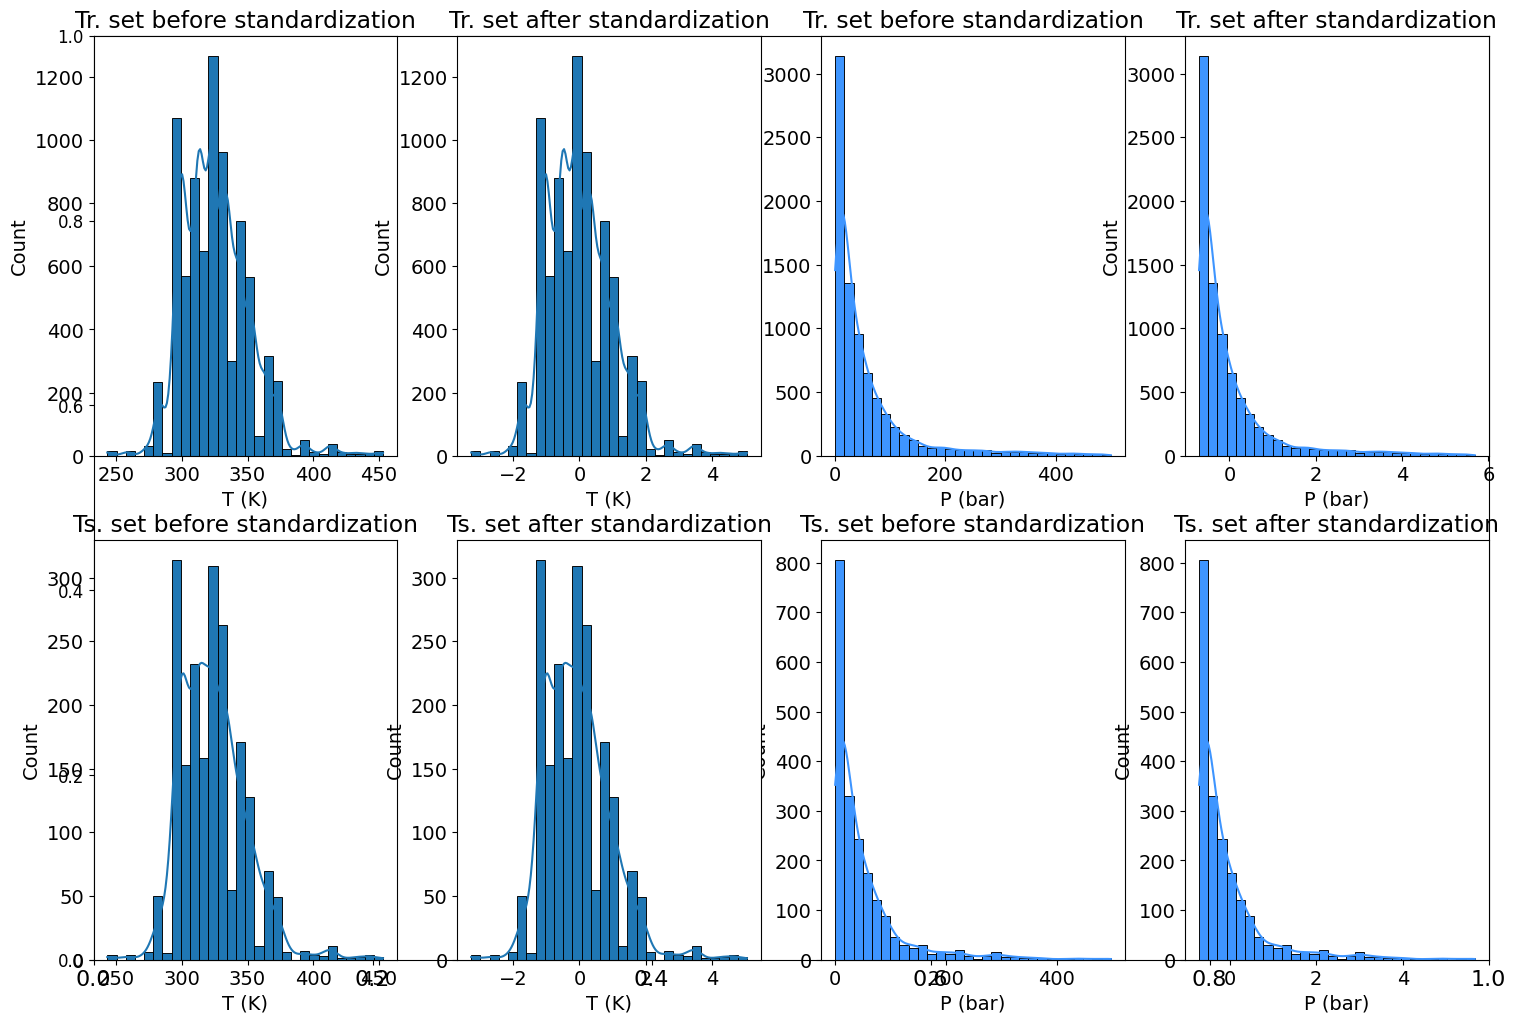

In [45]:
#######################################################################################
# graphic representation of the previous tables
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

nbins=30
fig = plt.figure(figsize=(18, 12))
plt.rcParams["font.size"] = (14) #font size
plt.tick_params(axis='x',labelsize = 16)
plt.tick_params(axis='y',labelsize = 12)
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

ax00=plt.subplot(gs[0,0], title="Tr. set before standardization")
fig00=sns.histplot(data=x_trainTmp,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax02=plt.subplot(gs[0,2], title="Tr. set before standardization")
fig02=sns.histplot(data=x_trainTmp,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)
ax01=plt.subplot(gs[0,1], title="Tr. set after standardization")
fig01=sns.histplot(data=x_train,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax03=plt.subplot(gs[0,3], title="Tr. set after standardization")
fig11=sns.histplot(data=x_train,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)

ax10=plt.subplot(gs[1,0], title="Ts. set before standardization")
fig10=sns.histplot(data=x_testTmp,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax12=plt.subplot(gs[1,2], title="Ts. set before standardization")
fig12=sns.histplot(data=x_testTmp,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)
ax11=plt.subplot(gs[1,1], title="Ts. set after standardization")
fig11=sns.histplot(data=x_test,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax13=plt.subplot(gs[1,3], title="Ts. set after standardization")
fig13=sns.histplot(data=x_test,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)


plt.savefig('./DS4B-CO2-images/Standardization_CO2data.png',dpi=300,bbox_inches='tight')

### Delete the scaled & Tmp dfs

In [46]:
del x_testTmp, x_trainTmp, xTP_test_scaled, xTP_train_scaled

### Now define and train the ANN

In [47]:
#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'
#acthL='relu'
if 'ANNmodel' in globals():
    del ANNmodel
if 'ANNhistory' in globals():
    del ANNhistory
ANNmodel=defANN( (53,), acthL )
ANNmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer (Dense)                  │ (None, 7)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386 (1.51 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
#######################################################################################
# optimization of the ANN
# library used: keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 25,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ytrain_hat=ANNmodel.predict(x_train)
ytest_hat=ANNmodel.predict(x_test)
# numpy.ravel() returns a contiguous flattened array
diffyt = ytrain_hat.flatten() - y_train.to_numpy()
diffyp = ytest_hat.flatten() - y_test.to_numpy()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt),
      "   std: ", np.std(diffyt),
      "   MAE: ", np.average(abs(diffyt)),
      "    R2: ", np.corrcoef(y_train.to_numpy(),ytrain_hat.flatten())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp),
      "   std: ", np.std(diffyp),
      "   MAE: ", np.average(abs(diffyp)),
      "    R2: ", np.corrcoef(y_test.to_numpy(),ytest_hat.flatten())[0,1]
     )


Epoch 1/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - mae: 0.0230 - mse: 0.0011 - val_loss: 0.0012 - val_mae: 0.0233 - val_mse: 0.0012
Epoch 2/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - mae: 0.0234 - mse: 0.0011 - val_loss: 0.0012 - val_mae: 0.0235 - val_mse: 0.0012
Epoch 3/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011 - val_loss: 0.0013 - val_mae: 0.0260 - val_mse: 0.0013
Epoch 4/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - mae: 0.0231 - mse: 0.0011 - val_loss: 0.0012 - val_mae: 0.0242 - val_mse: 0.0012
Epoch 5/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - mae: 0.0227 - mse: 0.0010 - val_loss: 0.0013 - val_mae: 0.0247 - val_mse: 0.0013
Epoch 6/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010 - mae: 0.0227 - mse: 0.0010 - val_loss: 0.0013 - val_mae: 0.0263 - val_mse: 0.0013
Epoch 7/200
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012 - mae: 0.0239 - mse: 0.001

### Save the Keras ANN model and the scaler for later use

In [50]:
# save the model
ANNmodel.save('./DS4B-CO2-SavedModels/ANNmodel-CO2-StandardizedB.keras')

# save the scalers
from pickle import dump
dump(scalerTP, open('./DS4B-CO2-SavedModels/scalerB_TP.pkl', 'wb'))

<div class="rqE">

Once completed, jump to the <a href="#model-evaluation">Model Evaluation</a> section

</div>

## Assessment of the stability of the ML model 2 by *K*-fold cross validation<a id="model4"></a>

<div class="rqE">Model 2 is now adapted to assess how the results of the ML generalizes</div>
<br>

<div class="intro">
The main idea behind cross-validation is that each sample in a dataset has the opportunity of being tested. K-fold cross-validation is a special case of cross-validation where we iterate over a dataset set <i>k</i> times. The dataset is split into <i>k</i> parts at each iteration: one part is used for validation, and the remaining <i>k</i>−1  parts are merged into a training subset for model evaluation. The figure below illustrates the process of 5-fold cross-validation
<p style="text-align: center"><img width="520px" src="DS4B-svg/KFoldCV.svg" style="margin-left:auto; margin-right:auto" id="img_5FoldCV"></p>
</div>

### Apply a 5-fold cross validation

In [51]:
# Resets all state generated by Keras
tf.keras.backend.clear_session()

In [52]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
xdata = dataCO2.drop(['IL','cation','anion','x_CO2'],axis=1)
xdataIL = xdata.drop(['T (K)','P (bar)'],axis=1)
xdataTP = xdata[['T (K)','P (bar)']]
ydata = dataCO2['x_CO2']

#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'

In [54]:
#######################################################################################
# optimization of the ANN
# library used: keras and scikit learn for the KFold cross-validator
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
from sklearn.model_selection import KFold
from sklearn import preprocessing
from pickle import dump

VERBOSE = 1
EPOCHS = 300
BATCH_SIZE = 25
N_SPLIT = 5

vID.chrono_start()

# variables created to save at each iteration of the KFold process: the mean error, the standard deviation, MAE, R2
meantT=list()
stdtT=list()
MAEtT=list()
R2tT=list()
meanvT=list()
stdvT=list()
MAEvT=list()
R2vT=list()

kfold = KFold(n_splits=N_SPLIT,shuffle=True,random_state=42) # k-fold is here!
#print(list(kfold.split(x_train,y_train)))

j = 0 # Variable for keeping count of split we are executing
# The KFold cv provides train/test indices to split data in train/test sets
for train_idx, val_idx in list(kfold.split(xdata,ydata)):

    xIL_train_cv = xdataIL.iloc[train_idx]
    xIL_valid_cv = xdataIL.iloc[val_idx]
    xTP_train_cv = xdataTP.iloc[train_idx]
    xTP_valid_cv = xdataTP.iloc[val_idx]
    y_train_cv = ydata.iloc[train_idx]
    y_valid_cv = ydata.iloc[val_idx]
#    display(x_train_cv,x_valid_cv)
    scalerTP = preprocessing.StandardScaler()
    scalerTP.fit(xTP_train_cv.values)
    xTPt_scaled = scalerTP.transform(xTP_train_cv.values) #returns a numpy array
    xTPv_scaled = scalerTP.transform(xTP_valid_cv.values) #returns a numpy array
    xtmp_train_cv = pd.DataFrame(xTPt_scaled, index=xTP_train_cv.index, columns=xTP_train_cv.columns) #conversion of a numpy array into a pandas dataframe
    xtmp_valid_cv = pd.DataFrame(xTPv_scaled, index=xTP_valid_cv.index, columns=xTP_valid_cv.columns) #conversion of a numpy array into a pandas dataframe
    x_train_cv = pd.concat([xtmp_train_cv,xIL_train_cv], axis=1)
    x_valid_cv = pd.concat([xtmp_valid_cv,xIL_valid_cv], axis=1)
    del xTPt_scaled, xTPv_scaled, xtmp_train_cv, xtmp_valid_cv, xIL_train_cv, xIL_valid_cv
    del xTP_train_cv, xTP_valid_cv
#    display(x_train_cv.describe().style.format("{0:.2f}").set_caption("Training set after normalization (with scikit-learn):"))
#    display(x_valid_cv.describe().style.format("{0:.2f}").set_caption("Validation set after normalization (with scikit-learn):"))
    print(f"{color.BOLD}{color.RED}Fold {j}{color.OFF}")
    j+=1
    ANNmodel=defANN( (53,), acthL )
    ANNhistory = ANNmodel.fit(x_train_cv,
                        y_train_cv,
                        epochs          = EPOCHS,
                        batch_size      = BATCH_SIZE,
                        verbose         = VERBOSE,
                        validation_data = (x_valid_cv, y_valid_cv),
                        callbacks=[es])
    ytrain_hat=ANNmodel.predict(x_train_cv)
    yvalid_hat=ANNmodel.predict(x_valid_cv)
    # numpy.ravel() returns a contiguous flattened array
    diffyt = ytrain_hat.flatten() - y_train_cv.to_numpy()
    diffyv = yvalid_hat.flatten() - y_valid_cv.to_numpy()

    print()
    print("xCO2(predicted) - xCO2(actual)")
    print(
          "Train.","mean: ", np.mean(diffyt),
          "   std: ", np.std(diffyt),
          "   MAE: ", np.average(abs(diffyt)),
          "    R2: ", np.corrcoef(y_train_cv.to_numpy(),ytrain_hat.flatten())[0,1]
         )
    print(
          "Test.","mean: ", np.mean(diffyv),
          "   std: ", np.std(diffyv),
          "   MAE: ", np.average(abs(diffyv)),
          "    R2: ", np.corrcoef(y_valid_cv.to_numpy(),yvalid_hat.flatten())[0,1]
         )
    meantT.append(np.mean(diffyt))
    meanvT.append(np.mean(diffyv))
    stdtT.append(np.std(diffyt))
    stdvT.append(np.std(diffyv))
    MAEtT.append(np.average(abs(diffyt)))
    MAEvT.append(np.average(abs(diffyv)))
    R2tT.append(np.corrcoef(y_train_cv.to_numpy(),ytrain_hat.flatten())[0,1])
    R2vT.append(np.corrcoef(y_valid_cv.to_numpy(),yvalid_hat.flatten())[0,1])
    
    # Save the Keras ANN model for later use    
    ModelName = './DS4B-CO2-SavedModels/ANNmodel-CO2-StandardizedB-' + str(j-1) + '.keras'
    ANNmodel.save(ModelName)
    # Scaler also saved!!!!!!!!!!!!!!
    ScalerName = './DS4B-CO2-SavedModels/scalerB-' + str(j-1) + '.pkl'
    dump(scalerTP, open(ScalerName, 'wb'))
    
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy
print(f"{color.BOLD}average MAE of the training set:{color.OFF}   {np.mean(MAEtT):.2f} +/- {np.std(MAEtT):.2f}")
print(f"{color.BOLD}average MAE of the validation set:{color.OFF} {np.mean(MAEvT):.2f} +/- {np.std(MAEvT):.2f}")

Fold 0
Epoch 1/300
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0676 - mae: 0.2012 - mse: 0.0676 - val_loss: 0.0185 - val_mae: 0.1063 - val_mse: 0.0185
Epoch 2/300
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - mae: 0.0967 - mse: 0.0154 - val_loss: 0.0099 - val_mae: 0.0752 - val_mse: 0.0099
Epoch 3/300
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085 - mae: 0.0700 - mse: 0.0085 - val_loss: 0.0066 - val_mae: 0.0605 - val_mse: 0.0066
Epoch 4/300
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - mae: 0.0571 - mse: 0.0057 - val_loss: 0.0050 - val_mae: 0.0529 - val_mse: 0.0050
Epoch 5/300
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - mae: 0.0493 - mse: 0.0045 - val_loss: 0.0040 - val_mae: 0.0463 - val_mse: 0.0040
Epoch 6/300
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - mae: 0.0450 - mse: 0.0037 - val_loss: 0.0034 - val_mae: 0.0430 - val_mse: 0.0034
Epoch 7/300
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - mae: 0.0421 - mse

### Visual assessment of the 5-fold cross validation

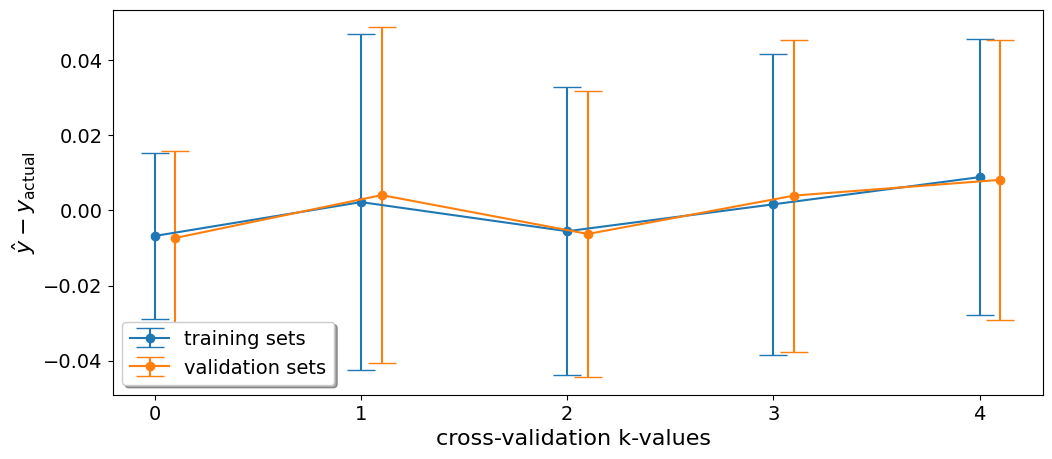

In [55]:
figCV, axCV = plt.subplots(1, 1)
figCV.set_size_inches(12,5)
axCV.errorbar(x=np.arange(len(meantT)), y=meantT, yerr=MAEtT, label='training sets', fmt='o-', capsize=10)
axCV.errorbar(x=np.arange(len(meanvT))+0.1, y=meanvT, yerr=MAEvT, label='validation sets', fmt='o-', capsize=10)
axCV.legend(loc='lower left', shadow=True, fontsize='14')
axCV.set_xlabel('cross-validation k-values ',fontdict={'fontsize':16})
axCV.set_ylabel('$\hat{y}-y_{\mathrm{actual}}$',fontdict={'fontsize':16})
axCV.tick_params(labelsize = 14)
plt.savefig('./DS4B-CO2-images/KFold-cv.png',dpi=300,bbox_inches='tight')
plt.show()

<div class="rqE">
Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. It generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split. Although the CO<sub>2</sub> data set contains more than 10k samples, it is always worth proving the stability of an ML algorithm. As a result, it is a pity that a scheme such as the one just determined above (and in principle close to the one reported below) is not available in the Song <i>et al.</i> publication, at least in the supplementary information part.
<p style="text-align: center"><img width="650px" src="./DS4B-CO2-images/KFold-cvK.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>
<b>This error plot shows a good performance of the ML algorithm, as well as similar error bars, regardless of the training data set.</b>
</div>

<div class="rqE">

**Do you want to evaluate the last optimized model of the K-fold process?**

evaluate the next Python cell for compatibility purpose with the **Model Evaluation** section
</div>

In [56]:
y_train = y_train_cv.copy()
y_test = y_valid_cv.copy()
ytest_hat = yvalid_hat.copy()

## Load and apply a previously saved model

### Load the database with unknown ILs

In [57]:
dataCO2newf='DS4B-CO2-data'+'/'+'dataCO2-new.csv'
dataCO2new=pd.read_csv(dataCO2newf,sep=";",header=0)
display(dataCO2new)
inputANN = dataCO2new.drop(['IL','cation','anion','xCO2 ref'],axis=1)

,IL,cation,anion,xCO2 ref,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.141,293.25,10.5,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,"[N4,1,1,1][PF6]","[N4,1,1,1]",[PF6],NaN,350.00,100.0,4,3,0,0,...,0,0,0,0,0,0,0,0,0,0
15,"[N4,1,1,1][PF6]","[N4,1,1,1]",[PF6],NaN,350.00,10.0,4,3,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class='rqE'>

The first ILs of this database have experimentally measured solubilities, whilst the major part have `NaN` unknown solubilities. They will be predicted for the temperature and pressure given in the table.
</div>

### Initial model of the reference paper

In [58]:
from tensorflow.keras.models import load_model

# load models
BasicModel= load_model('./DS4B-CO2-SavedModels/ANNmodel-CO2-basic.keras')
# summarize model.
BasicModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer (Dense)                  │ (None, 7)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160 (4.54 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 774 (3.03 KB)

In [59]:
dataCO2new_withPredictions = dataCO2new[['IL','cation','anion','xCO2 ref','T (K)','P (bar)']].copy()
xCO2newBasic = BasicModel.predict(inputANN)
dataCO2new_withPredictions.insert(loc = 4, column = 'xCO2 BM', value = xCO2newBasic)

pd.options.display.max_rows = len(dataCO2new_withPredictions)
display(dataCO2new_withPredictions)
pd.options.display.max_rows = 5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


,IL,cation,anion,xCO2 ref,xCO2 BM,T (K),P (bar)
0,[BMIM][BF4],[BMIM],[BF4],0.6100,0.573097,363.15,246.00
1,[BMIM][BF4],[BMIM],[BF4],0.1410,0.144968,293.25,10.50
2,[(ETO)2IM][Tf2N],[(ETO)2IM],[Tf2N],0.8120,0.802447,322.15,328.60
3,[BMIM][NO3],[BMIM],[NO3],0.4704,0.393783,313.20,93.16
4,"[N4,1,1,1][C3F7CO2]","[N4,1,1,1]",[C3F7CO2],NaN,0.733624,293.00,100.00
5,"[N4,1,1,1][C3F7CO2]","[N4,1,1,1]",[C3F7CO2],NaN,0.130675,293.00,10.00
6,"[N4,1,1,1][C3F7CO2]","[N4,1,1,1]",[C3F7CO2],NaN,0.564136,350.00,100.00
7,"[N4,1,1,1][C3F7CO2]","[N4,1,1,1]",[C3F7CO2],NaN,0.028479,350.00,10.00
8,"[N4,1,1,1][methide]","[N4,1,1,1]",[methide],NaN,0.787256,293.00,100.00
9,"[N4,1,1,1][methide]","[N4,1,1,1]",[methide],NaN,0.258274,293.00,10.00


### Models 3, *i.e.* model 2 validated by *k*-fold cross validation

In [60]:
dataCO2new_withPredictions = dataCO2new[['IL','cation','anion','xCO2 ref','T (K)','P (bar)']].copy()
dataCO2new_withPredictions.insert(loc = 4, column = 'xCO2 BM', value = xCO2newBasic)

from sklearn import preprocessing
from pickle import load as loadScaler

inputANNIL = inputANN.drop(['T (K)','P (bar)'],axis=1)
inputANNTP = inputANN[['T (K)','P (bar)']]

for i in range(5):
    #del nameModel
    scalerName = "./DS4B-CO2-SavedModels/scalerB-" + str(i) + ".pkl"
    scalerTP = loadScaler(open(scalerName, 'rb'))
    nameModelVar = f'ModelStzB{i}'
    fileName =  "./DS4B-CO2-SavedModels/ANNmodel-CO2-StandardizedB-" + str(i) + ".keras"
    exec("%s = '%s'" %("nameModel",nameModelVar))
    columnName = 'xCO2 StzB'+str(i)
    print(f"{bg.DARKREDB}ANN model {nameModelVar} (file = {fileName}). xCO2 will be stored in the {columnName} column{bg.OFF}")
    nameModel = load_model(fileName)
    nameModel.summary()
    
    inputANNTP_scaled = scalerTP.transform(inputANNTP.values) #returns a numpy array
    dfinputANNTP_scaled = pd.DataFrame(inputANNTP_scaled, index=inputANNTP.index, columns=inputANNTP.columns)
    inputANNB = pd.concat([dfinputANNTP_scaled,inputANNIL], axis=1)
    
    xCO2new = nameModel.predict(inputANNB)
    dataCO2new_withPredictions.insert(loc = 5+i, column = columnName, value = xCO2new)
    
pd.options.display.max_rows = len(dataCO2new_withPredictions)
display(dataCO2new_withPredictions)
pd.options.display.max_rows = 5

ANN model ModelStzB0 (file = ./DS4B-CO2-SavedModels/ANNmodel-CO2-StandardizedB-0.keras). xCO2 will be stored in the xCO2 StzB0 column


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer (Dense)                  │ (None, 7)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160 (4.54 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 774 (3.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
ANN model ModelStzB1 (file = ./DS4B-CO2-SavedModels/ANNmodel-CO2-StandardizedB-1.keras). xCO2 will be stored in the xCO2 StzB1 column


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer (Dense)                  │ (None, 7)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160 (4.54 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 774 (3.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
ANN model ModelStzB2 (file = ./DS4B-CO2-SavedModels/ANNmodel-CO2-StandardizedB-2.keras). xCO2 will be stored in the xCO2 StzB2 column


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer (Dense)                  │ (None, 7)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160 (4.54 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 774 (3.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
ANN model ModelStzB3 (file = ./DS4B-CO2-SavedModels/ANNmodel-CO2-StandardizedB-3.keras). xCO2 will be stored in the xCO2 StzB3 column


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer (Dense)                  │ (None, 7)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160 (4.54 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 774 (3.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
ANN model ModelStzB4 (file = ./DS4B-CO2-SavedModels/ANNmodel-CO2-StandardizedB-4.keras). xCO2 will be stored in the xCO2 StzB4 column


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer (Dense)                  │ (None, 7)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160 (4.54 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 774 (3.03 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


,IL,cation,anion,xCO2 ref,xCO2 BM,xCO2 StzB0,xCO2 StzB1,xCO2 StzB2,xCO2 StzB3,xCO2 StzB4,T (K),P (bar)
0,[BMIM][BF4],[BMIM],[BF4],0.6100,0.573097,0.529024,0.538152,0.562893,0.439504,0.501315,363.15,246.00
1,[BMIM][BF4],[BMIM],[BF4],0.1410,0.144968,0.173311,0.171326,0.171221,0.181061,0.170417,293.25,10.50
2,[(ETO)2IM][Tf2N],[(ETO)2IM],[Tf2N],0.8120,0.802447,0.759499,0.787429,0.827527,0.812260,0.808870,322.15,328.60
3,[BMIM][NO3],[BMIM],[NO3],0.4704,0.393783,0.434586,0.466652,0.493629,0.536086,0.547457,313.20,93.16
4,"[N4,1,1,1][C3F7CO2]","[N4,1,1,1]",[C3F7CO2],NaN,0.733624,0.802034,0.877161,0.803591,1.064347,0.820947,293.00,100.00
5,"[N4,1,1,1][C3F7CO2]","[N4,1,1,1]",[C3F7CO2],NaN,0.130675,0.164957,0.056132,0.145250,0.302043,0.150446,293.00,10.00
6,"[N4,1,1,1][C3F7CO2]","[N4,1,1,1]",[C3F7CO2],NaN,0.564136,0.642902,0.737751,0.535731,0.803456,0.702621,350.00,100.00
7,"[N4,1,1,1][C3F7CO2]","[N4,1,1,1]",[C3F7CO2],NaN,0.028479,0.104916,-0.011082,0.027063,0.137185,0.048718,350.00,10.00
8,"[N4,1,1,1][methide]","[N4,1,1,1]",[methide],NaN,0.787256,0.889506,0.930587,0.906149,1.009952,0.876313,293.00,100.00
9,"[N4,1,1,1][methide]","[N4,1,1,1]",[methide],NaN,0.258274,0.307013,0.105098,0.255311,0.265024,0.230136,293.00,10.00


<a id="model-evaluation"></a>
## Model evaluation

### Loss, MAE and MSE as a function of epochs = during the ANN optimization with the back-propagation algorithm 

x_train / loss      : 0.0068
x_train / mae       : 0.0643
x_train / mse       : 0.0068

x_test / loss       : 0.0073
x_test / mae        : 0.0672
x_test / mse        : 0.0073


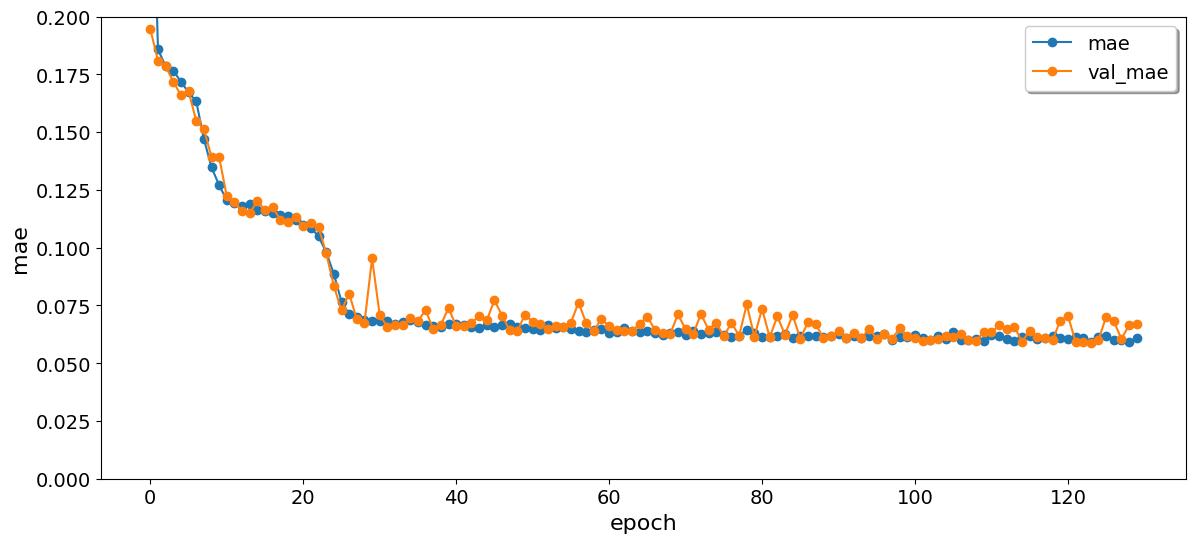

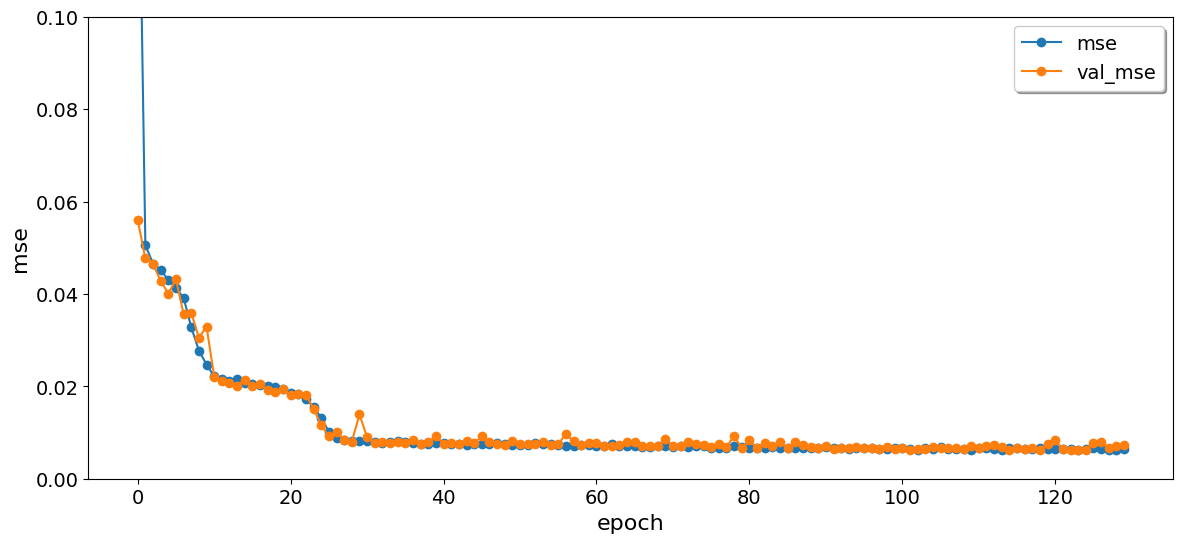

In [28]:
ANNscoreTrain= ANNmodel.evaluate(x_train, y_train, verbose=0)
print(f"{color.GREEN}x_train / loss      : {ANNscoreTrain[0]:5.4f}")
print(f"x_train / mae       : {ANNscoreTrain[1]:5.4f}")
print(f"x_train / mse       : {ANNscoreTrain[2]:5.4f}{color.OFF}")
print()
ANNscoreEval = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(f"{color.BLUE}x_test / loss       : {ANNscoreEval[0]:5.4f}")
print(f"x_test / mae        : {ANNscoreEval[1]:5.4f}")
print(f"x_test / mse        : {ANNscoreEval[2]:5.4f}{color.OFF}")

df=pd.DataFrame(data=ANNhistory.history)
plt.rcParams["figure.figsize"] = (14,6)
figMAE=df.plot(y=["mae","val_mae"],linestyle='-', marker='o',fontsize=14)
figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
figMAE.set_ylabel('mae',fontdict={'fontsize':16})
figMAE.set_ylim([0.0,0.2])
figMAE.legend(loc='upper right', shadow=True, fontsize='14')
figMSE=df.plot(y=["mse","val_mse"],linestyle='-', marker='o',fontsize=14)
figMSE.set_xlabel('epoch',fontdict={'fontsize':16})
figMSE.set_ylabel('mse',fontdict={'fontsize':16})
figMSE.set_ylim([0.0,0.1])
figMSE.legend(loc='upper right', shadow=True, fontsize='14')

### Comparison between experimental and predicted CO<sub>2</sub> solubility

KeyboardInterrupt: 

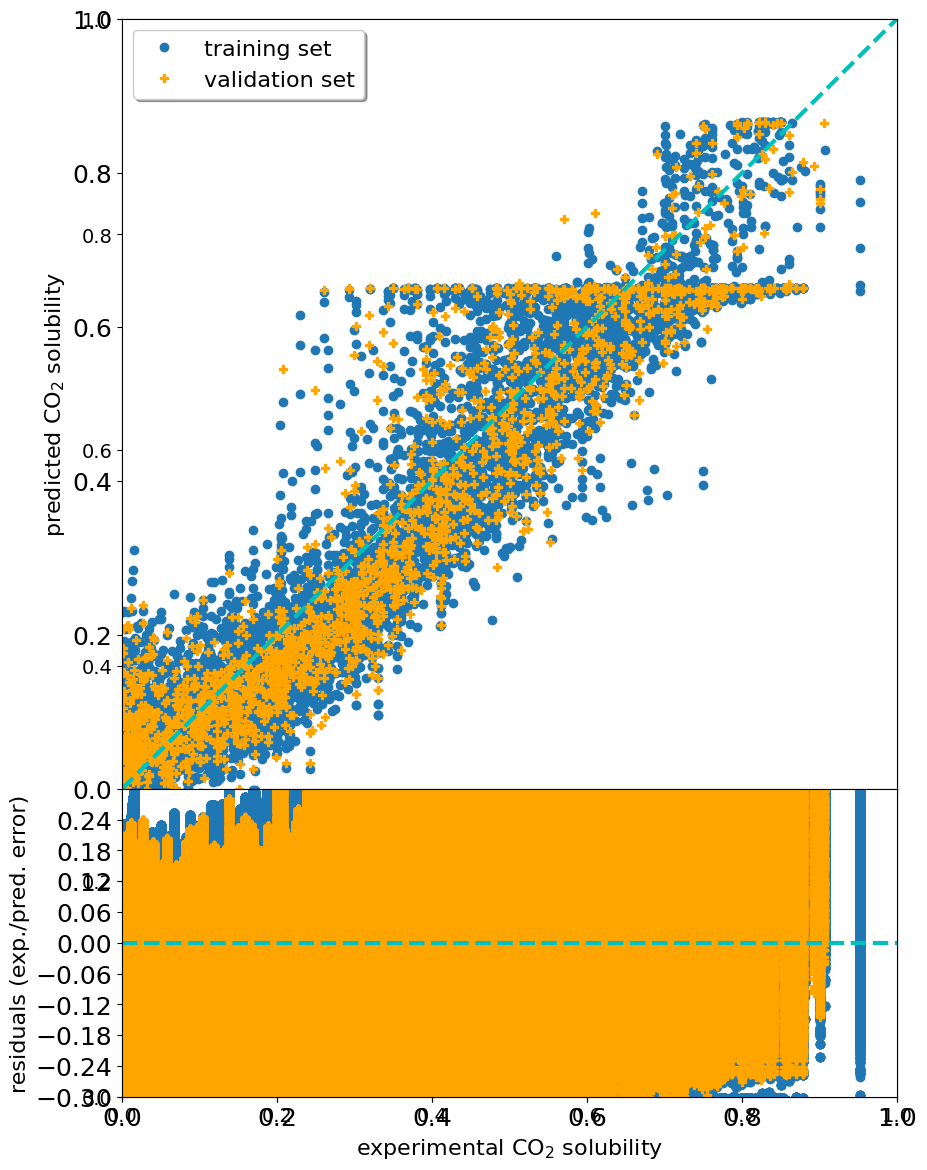

In [29]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

xD=[0,1]
yD=[0,1]
fig = plt.figure(figsize=(10, 14))
plt.rcParams["font.size"] = (18) #font size
plt.tick_params(labelsize = 14)
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 4], hspace=0)
ax0=plt.subplot(gs[0])
ax0.plot(y_train,ytrain_hat,'o',color="#1f77b4",label='training set')
ax0.plot(y_test,ytest_hat,'P',color="orange",label='validation set')
ax0.plot(xD,yD,'c',linestyle='--',lw=3)
ax0.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
ax0.set_ylabel('predicted CO$_2$ solubility',fontsize=16)
ax0.set_xlim(0,1);ax0.set_ylim(0,1) 
ax0.legend(loc='upper left', shadow=True, fontsize='16')
plt.setp(ax0.get_xticklabels(), visible=False) #cosmetics

ax1=plt.subplot(gs[1])
ax1.plot(y_train,diffyt,'o',color="#1f77b4",label='training set')
ax1.plot(y_test,diffyp,'P',color="orange",label='validation set')
ax1.axhline(y=0, xmin=0., xmax=1.0, color='c', linestyle='--', linewidth=3)
ax1.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
ax1.set_ylabel('residuals (exp./pred. error)',fontsize=16)
ax1.set_xlim(0.0,1.0); ax1.set_ylim(-0.3,0.3)
ax1.axes.get_yaxis().set_major_locator(MaxNLocator(prune='upper'))  #cosmetics

plt.savefig('./DS4B-CO2-images/predictionCO2.png',dpi=300,bbox_inches='tight')

### Residuals plotted as histograms (distribution of the error)

 Train. mean: 0.009    std: 0.049    MAE: 0.037     R2: 0.978
  Test. mean: -0.005    std: 0.033    MAE: 0.023     R2: 0.977


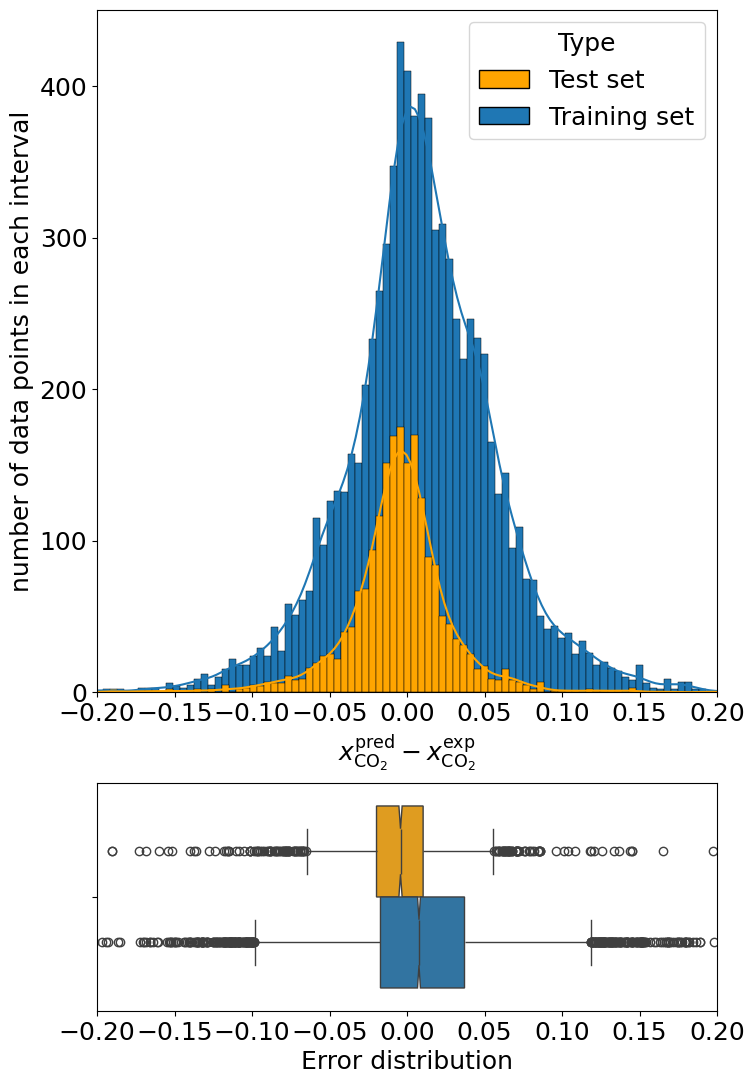

In [66]:
# numpy.ravel() returns a contiguous flattened array
print(color.BLUE,
      "Train.","mean: {:.3f}".format(np.mean(diffyt)),
      "   std: {:.3f}".format(np.std(diffyt)),
      "   MAE: {:.3f}".format(np.average(abs(diffyt))),
      "    R2: {:.3f}".format(np.corrcoef(y_train.to_numpy(),ytrain_hat.flatten())[0,1])
     )
print(color.YELLOW,
      " Test.","mean: {:.3f}".format(np.mean(diffyp)),
      "   std: {:.3f}".format(np.std(diffyp)),
      "   MAE: {:.3f}".format(np.average(abs(diffyp))),
      "    R2: {:.3f}".format(np.corrcoef(y_test.to_numpy(),ytest_hat.flatten())[0,1])
     )

# make a dataframe
df1 = pd.DataFrame(
    {
        "Error distribution": diffyp,
        "Type": 'Test set'    },
)
#display(df1)
df2 = pd.DataFrame(
    {
        "Error distribution": diffyt,
        "Type": 'Training set'    },
)
#display(df2)
distrib=pd.concat([df1,df2],ignore_index=True)
#display(distrib)

xlim=0.2
nbins=120

import matplotlib.gridspec as gridspec
plt.rcParams["figure.figsize"] = (8,13) #graphic size
plt.rcParams["font.size"] = (18) #font size
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
plt.subplot(gs[0])
fig1=sns.histplot(data=distrib,x="Error distribution", hue="Type", bins=nbins, kde=True, palette=['Orange','#1f77b4'], alpha=1.0)
plt.xlabel("$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$")
plt.ylabel("number of data points in each interval")
plt.xlim(-xlim,xlim)
plt.subplot(gs[1])
plt.xlim(-xlim,xlim)
fig2=sns.boxplot(data=distrib, x="Error distribution", hue="Type", notch=True, orient = 'h',palette=['Orange','#1f77b4'],legend=False)
fig2.set(ylabel=None)
plt.savefig('./DS4B-CO2-images/errorCO2.png',dpi=300,bbox_inches='tight')

### Identify the most significant failures?

#### Save y_hat of the training and of the test set in the dataCO2 dataframe

In [67]:
display(dataCO2)
df_ytrain_hat = pd.DataFrame(ytrain_hat,index=x_train.index,columns=["x_CO2_hat"])
df_ytrain_hat["set"] = "train"
#display(df_ytrain_hat)
df_ytest_hat = pd.DataFrame(ytest_hat,index=x_test.index,columns=["x_CO2_hat_tss"])
df_ytest_hat["set_tss"] = "test"
#display(df_ytest_hat)
dataCO2_hat = pd.concat([dataCO2,df_ytrain_hat,df_ytest_hat],axis=1)
dataCO2_hat['x_CO2_hat'].update(dataCO2_hat.pop('x_CO2_hat_tss'))
dataCO2_hat['set'].update(dataCO2_hat.pop('set_tss'))
display(dataCO2_hat)

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10115,[HMIM][Tf2N],[HMIM],[Tf2N],0.139,323.15,8.00,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_27953/2691265262.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataCO2_hat['x_CO2_hat'].update(dataCO2_hat.pop('x_CO2_hat_tss'))
/tmp/ipykernel_27953/2691265262.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide],x_CO2_hat,set
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0.447898,train
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0.315067,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0.777365,train
10115,[HMIM][Tf2N],[HMIM],[Tf2N],0.139,323.15,8.00,1,5,0,0,...,0,0,0,0,0,0,0,0,0.747120,train


#### Calculate residuals and relative errors

<div class="intro">
    
They will be stored in a new `dataCO2_hat` dataframe
</div>

In [69]:
dataCO2_hat["residual"] = dataCO2_hat.loc[:,["x_CO2","x_CO2_hat"]].apply(lambda x: x.iloc[0]-x.iloc[1], axis=1)
dataCO2_hat["relative err."] = dataCO2_hat.loc[:,["x_CO2","x_CO2_hat"]].apply(lambda x: round(100*abs(x.iloc[0]-x.iloc[1])/x.iloc[0],1), axis=1)
move = "x_CO2_hat"
column_to_move = dataCO2_hat.pop(move)
dataCO2_hat.insert(6, move, column_to_move)
move = "residual"
column_to_move = dataCO2_hat.pop(move)
dataCO2_hat.insert(7, move, column_to_move)
move = "relative err."
column_to_move = dataCO2_hat.pop(move)
dataCO2_hat.insert(8, move, column_to_move)
move = "set"
column_to_move = dataCO2_hat.pop(move)
dataCO2_hat.insert(9, move, column_to_move)
display(dataCO2_hat)

,IL,cation,anion,x_CO2,T (K),P (bar),x_CO2_hat,residual,relative err.,set,...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,0.447898,0.162102,26.6,train,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,0.315067,0.184933,37.0,train,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,0.777365,-0.637365,455.3,train,...,0,0,0,0,0,0,0,0,0,0
10115,[HMIM][Tf2N],[HMIM],[Tf2N],0.139,323.15,8.00,0.747120,-0.608120,437.5,train,...,0,0,0,0,0,0,0,0,0,0


#### Highlight the most significant errors

In [70]:
threshold = 0.20
dataCO2_Large_Error = dataCO2_hat.query("abs(residual) >= @threshold")
display(dataCO2_Large_Error)
dataCO2_Large_Error.to_csv("./DS4B-CO2-data/dataCO2_withPrediction_Wrong.csv")
dataCO2_Small_Error = dataCO2_hat.query("abs(residual) < @threshold")
display(dataCO2_Small_Error)
dataCO2_Small_Error.to_csv("./DS4B-CO2-data/dataCO2_withPrediction_Right.csv")

,IL,cation,anion,x_CO2,T (K),P (bar),x_CO2_hat,residual,relative err.,set,...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,0.160859,0.449141,73.6,train,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,0.100139,0.399861,80.0,train,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,0.777365,-0.637365,455.3,train,...,0,0,0,0,0,0,0,0,0,0
10115,[HMIM][Tf2N],[HMIM],[Tf2N],0.139,323.15,8.00,0.747120,-0.608120,437.5,train,...,0,0,0,0,0,0,0,0,0,0


,IL,cation,anion,x_CO2,T (K),P (bar),x_CO2_hat,residual,relative err.,set,...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,0.447898,0.162102,26.6,train,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,0.315067,0.184933,37.0,train,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,0.279761,-0.040761,17.1,train,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,0.388483,0.007517,1.9,test,...,0,0,0,0,0,0,0,0,0,0


#### Plot x_CO2 & x_CO2_hat = f(T,P) for a given IL (bogus part...)

##### Wrong predictions

In [ ]:
# import plotly.graph_objects as go 
# import plotly.offline as off
# from scipy.interpolate import griddata

# off.init_notebook_mode()

# TN = 'T (K)'
# PN = 'P (bar)'
# xCO2N = 'x_CO2'
# xCO2hatN = 'x_CO2_hat'
# #### Choose an IL that belongs to the dataCO2_Large_Error dataframe
# ILN = '[HMIM][BF4]'

# #Create meshgrid for T & P
# Ti = np.linspace(min(dataCO2_hat.query("IL == @ILN")[TN]), max(dataCO2_hat.query("IL == @ILN")[TN]), num=100)
# Pi = np.linspace(min(dataCO2_hat.query("IL == @ILN")[PN]), max(dataCO2_hat.query("IL == @ILN")[PN]), num=100)

# T_grid, P_grid = np.meshgrid(Ti,Pi)

# # Grid data
# xCO2_grid = griddata((dataCO2_hat.query("IL == @ILN")[TN],dataCO2_hat.query("IL == @ILN")[PN]),dataCO2_hat.query("IL == @ILN")[xCO2N],(T_grid,P_grid),method='cubic')
# xCO2_hat_grid = griddata((dataCO2_hat.query("IL == @ILN")[TN],dataCO2_hat.query("IL == @ILN")[PN]),dataCO2_hat.query("IL == @ILN")[xCO2hatN],(T_grid,P_grid),method='cubic')


# # Plotly 3D Surface
# fig_ref = go.Surface(x=T_grid,y=P_grid,z=xCO2_grid,
#                        colorscale='viridis')
# fig_hat = go.Surface(x=T_grid,y=P_grid,z=xCO2_hat_grid,
#                        colorscale='greys')

# layout = go.Layout(title='CO$_2$ solubility', autosize=False,
#                   width=700, height=700,
#                   margin=dict(l=65, r=50, b=65, t=90),
#                   scene=dict(
#                             xaxis_title=TN,
#                             yaxis_title=PN,
#                             zaxis_title=xCO2N,
#     ),
#                  )
# off.iplot({"data": [fig_ref, fig_hat],"layout": layout})


##### Good predictions

In [ ]:
# import plotly.graph_objects as go 
# import plotly.offline as off
# from scipy.interpolate import griddata

# off.init_notebook_mode()

# TN = 'T (K)'
# PN = 'P (bar)'
# xCO2N = 'x_CO2'
# xCO2hatN = 'x_CO2_hat'
# #### Choose an IL that belongs to the dataCO2_Small_Error dataframe
# ILN = '[BMIM][BF4]'

# #Create meshgrid for T & P
# Ti = np.linspace(min(dataCO2_hat.query("IL == @ILN")[TN]), max(dataCO2_hat.query("IL == @ILN")[TN]), num=100)
# Pi = np.linspace(min(dataCO2_hat.query("IL == @ILN")[PN]), max(dataCO2_hat.query("IL == @ILN")[PN]), num=100)

# T_grid, P_grid = np.meshgrid(Ti,Pi)

# # Grid data
# xCO2_grid = griddata((dataCO2_hat.query("IL == @ILN")[TN],dataCO2_hat.query("IL == @ILN")[PN]),dataCO2_hat.query("IL == @ILN")[xCO2N],(T_grid,P_grid),method='cubic')
# xCO2_hat_grid = griddata((dataCO2_hat.query("IL == @ILN")[TN],dataCO2_hat.query("IL == @ILN")[PN]),dataCO2_hat.query("IL == @ILN")[xCO2hatN],(T_grid,P_grid),method='cubic')

# # Plotly 3D Surface
# fig_ref = go.Surface(x=T_grid,y=P_grid,z=xCO2_grid,
#                        colorscale='viridis')
# fig_hat = go.Surface(x=T_grid,y=P_grid,z=xCO2_hat_grid,
#                        colorscale='greys')

# layout = go.Layout(title='CO$_2$ solubility', autosize=False,
#                   width=700, height=700,
#                   margin=dict(l=65, r=50, b=65, t=90),
#                   scene=dict(
#                             xaxis_title=TN,
#                             yaxis_title=PN,
#                             zaxis_title=xCO2N,
#     ),
#                  )
# off.iplot({"data": [fig_ref, fig_hat],"layout": layout})


## "Simple" exercise

<div class="exE" title="Optimize the hyperparameters of Model 2 by hand">

Return to the <a href="#model2">corresponding section</a> and change some hyperparameters. Carefully note the accuracy of each attempt, and watch out for a possible overfitting. Suggestions:
- Try to increase the number of neurons of the hidden layer
- Replace the `tanh` activation function with the `relu` activation function
- Add a second hidden layer (this is **deep learning**!)

Do you find a better model than the original model 2?
</div>

## Appendix: activation functions

In [71]:
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)
pw=4
ph=4


### relu function

$$R(z)=\begin{cases}
\begin{array}{cc}
z & \,\,\,\,\,\,\,z>0\\
0 & \,\,\,\,\,\,\,z\leq0
\end{array}\end{cases}$$

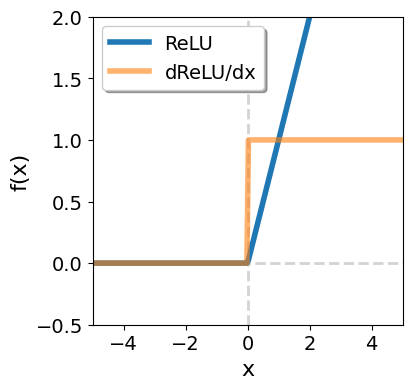

In [72]:
def relu(z):
    return np.maximum(0, z)

figR, axR = plt.subplots(1, 1)
figR.set_size_inches(pw,ph)
axR.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axR.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axR.plot(z, relu(z),linewidth=4,label="ReLU")
axR.plot(z, derivative(relu, z), linewidth=4, alpha=0.6, label="dReLU/dx")
axR.legend(loc='upper left', shadow=True, fontsize='14')
axR.set_xlabel('x',fontdict={'fontsize':16})
axR.set_ylabel('f(x)',fontdict={'fontsize':16})
axR.set_xlim(-5, 5)
axR.set_ylim(-0.5, 2)
axR.tick_params(labelsize = 14)
plt.show()


### tanh function

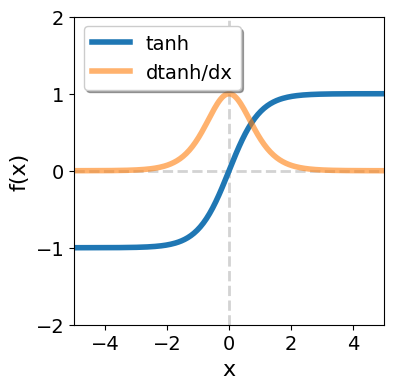

In [73]:
def tanh(z):
    return np.tanh(z)

figT, axT = plt.subplots(1, 1)
figT.set_size_inches(pw,ph)
axT.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axT.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axT.plot(z, tanh(z),linewidth=4,label="tanh")
axT.plot(z, derivative(tanh, z), linewidth=4, alpha=0.6, label="dtanh/dx")
axT.legend(loc='upper left', shadow=True, fontsize='14')
axT.set_xlabel('x',fontdict={'fontsize':16})
axT.set_ylabel('f(x)',fontdict={'fontsize':16})
axT.set_xlim(-5, 5)
axT.set_ylim(-2, 2)
axT.tick_params(labelsize = 14)
plt.show()


### softmax function
$$\sigma_{i}(\boldsymbol{x})=\frac{e^{x_{i}}}{\sum_{j=1}^{K}e^{x_{j}}}$$

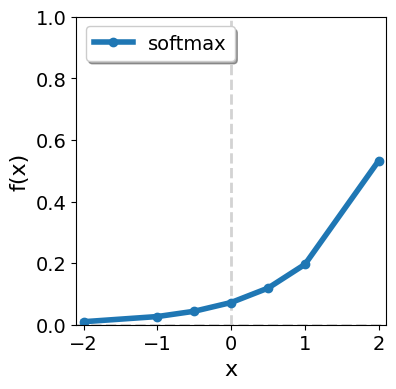

Sum of softmax values: 1.0


In [74]:
def softmax(x):
    e_x = np.exp(x - np.max(x)) #this implentation has a better numerical stability
    return e_x / e_x.sum()

z2 = [-2., -1., -0.5, 0., 0.5, 1., 2.]
figS, axS = plt.subplots(1, 1)
figS.set_size_inches(pw,ph)
axS.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axS.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axS.plot(z2, softmax(z2),linewidth=4,marker='o',label="softmax")
axS.legend(loc='upper left', shadow=True, fontsize='14')
axS.set_xlabel('x',fontdict={'fontsize':16})
axS.set_ylabel('f(x)',fontdict={'fontsize':16})
axS.set_xlim(-2.1, 2.1)
axS.set_ylim(0., 1.0)
axS.tick_params(labelsize = 14)
plt.show()
print(f"Sum of softmax values: {softmax(z2).sum()}")

In [75]:
vID.end(cwd0)

**End at:** Wednesday 27 March 2024, 13:42:36  
**Duration:** 01:15:27 861ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>

# END